# Importing modules # 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
from sklearn.metrics import silhouette_score
import re
from matplotlib.pyplot import figure

from sklearn import metrics
from pandas.io.formats.style_render import DataFrame
from tqdm import tqdm
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from math import ceil
from sklearn.cluster import AgglomerativeClustering

from scipy.stats import mode
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram

# Connect to Drive # 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!cp /content/drive/Shareddrives/DM_Project/dataset/users_clustering.csv /content/
!cp /content/drive/Shareddrives/DM_Project/dataset/users_extended.csv /content/

# Defining some utility functions

In [ ]:
figsize = (20, 5)

def plot_boxplot_grid(data_list, n_cols = 4, figsize= (10, 10)):

  n = len(data_list)
  n_rows = ceil(n/n_cols)

  fig, ax = plt.subplots(n_rows, n_cols, figsize=figsize)
  row = 0
  col = 0

  tot = n_cols*n_rows

  if n_rows > 1:
    for i in range(tot):
      if i < n:
        ax[row, col].boxplot(data_list[i])
        ax[row, col].set_title(f"Cluster {i}")
      else:
        ax[row, col].set_xticks([])
        ax[row, col].set_yticks([])
        ax[row, col].spines['top'].set_visible(False)
        ax[row, col].spines['bottom'].set_visible(False)
        ax[row, col].spines['left'].set_visible(False)
        ax[row, col].spines['right'].set_visible(False)
      col += 1
      if col == n_cols:
        col = 0
        row += 1
  else:
    for i in range(tot):
      if i < n:
        ax[col].boxplot(data_list[i])
        ax[col].set_title(f"Cluster {i}")
      else:
        ax[col].set_xticks([])
        ax[col].set_yticks([])
        ax[col].spines['top'].set_visible(False)
        ax[col].spines['bottom'].set_visible(False)
        ax[col].spines['left'].set_visible(False)
        ax[col].spines['right'].set_visible(False)
      col += 1

  plt.show()

def plot_bar_grid(data_list, n_cols = 4, figsize= (10, 10)):

  n = len(data_list)
  n_rows = ceil(n/n_cols)

  fig, ax = plt.subplots(n_rows, n_cols, figsize=figsize)
  row = 0
  col = 0

  tot = n_cols*n_rows

  if n_rows > 1:
    for i in range(tot):
      if i < n:
        x, y = data_list[i]
        ax[row, col].bar(x, y)
        ax[row, col].set_title(f"Cluster {i}")
      else:
        ax[row, col].set_xticks([])
        ax[row, col].set_yticks([])
        ax[row, col].spines['top'].set_visible(False)
        ax[row, col].spines['bottom'].set_visible(False)
        ax[row, col].spines['left'].set_visible(False)
        ax[row, col].spines['right'].set_visible(False)
      col += 1
      if col == n_cols:
        col = 0
        row += 1
  else:
    for i in range(tot):
      if i < n:
        x, y = data_list[i]
        ax[col].bar(x, y)
        ax[col].set_title(f"Cluster {i}")
      else:
        ax[col].set_xticks([])
        ax[col].set_yticks([])
        ax[col].spines['top'].set_visible(False)
        ax[col].spines['bottom'].set_visible(False)
        ax[col].spines['left'].set_visible(False)
        ax[col].spines['right'].set_visible(False)
      col += 1


  plt.show()



def plot_hist_grid(data_list, n_cols = 4, n_bins = 10, figsize= (10, 10)):

  n = len(data_list)
  n_cols = 4
  n_rows = ceil(n/n_cols)

  fig, ax = plt.subplots(n_rows, n_cols, figsize=figsize)
  row = 0
  col = 0

  tot = n_cols*n_rows

  if n_rows > 1:
    for i in range(tot):
      if i < n:
        ax[row, col].hist(data_list[i], bins=n_bins)
        ax[row, col].set_title(f"Cluster {i}")
      else:
        ax[row, col].set_xticks([])
        ax[row, col].set_yticks([])
        ax[row, col].spines['top'].set_visible(False)
        ax[row, col].spines['bottom'].set_visible(False)
        ax[row, col].spines['left'].set_visible(False)
        ax[row, col].spines['right'].set_visible(False)
      col += 1
      if col == n_cols:
        col = 0
        row += 1
  else:
    for i in range(tot):
      if i < n:
        ax[col].hist(data_list[i], bins=n_bins)
        ax[col].set_title(f"Cluster {i}")
      else:
        ax[col].set_xticks([])
        ax[col].set_yticks([])
        ax[col].spines['top'].set_visible(False)
        ax[col].spines['bottom'].set_visible(False)
        ax[col].spines['left'].set_visible(False)
        ax[col].spines['right'].set_visible(False)
      col += 1

  plt.show()


def print_overlapping_histograms(data_list, n_bins=None, figsize=(12,8)):

  if n_bins == None:
    n_bins = [20 for x in range(len(data_list))]

  plt.figure(figsize=figsize)
  for i in range(len(data_list)):
    plt.hist(data_list[i], bins=n_bins[i], alpha=0.5, label=f"Cluster {i}", density=True)
  plt.legend()
  plt.show()

# Load dataset # 

In [ ]:
users_clustering = pd.read_csv("users_clustering.csv")
users = pd.read_csv("users_extended.csv")

In [ ]:
users_clustering.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11508 entries, 0 to 11507
Data columns (total 32 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      11508 non-null  int64  
 1   name                    11508 non-null  object 
 2   lang                    11508 non-null  object 
 3   bot                     11508 non-null  int64  
 4   created_at              11508 non-null  object 
 5   statuses_count          11508 non-null  int64  
 6   reply_count_total       11508 non-null  float64
 7   favorite_count_total    11508 non-null  int64  
 8   num_hashtags_total      11508 non-null  int64  
 9   retweet_count_avg       11508 non-null  float64
 10  reply_count_avg         11508 non-null  float64
 11  favorite_count_avg      11508 non-null  float64
 12  num_hashtags_avg        11508 non-null  float64
 13  num_urls_avg            11508 non-null  float64
 14  num_mentions_avg        11508 non-null

# Selecting data for clustering  # 

In [ ]:
selected = users_clustering.columns.tolist()[5:]
data = users_clustering[selected]
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11508 entries, 0 to 11507
Data columns (total 27 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   statuses_count          11508 non-null  int64  
 1   reply_count_total       11508 non-null  float64
 2   favorite_count_total    11508 non-null  int64  
 3   num_hashtags_total      11508 non-null  int64  
 4   retweet_count_avg       11508 non-null  float64
 5   reply_count_avg         11508 non-null  float64
 6   favorite_count_avg      11508 non-null  float64
 7   num_hashtags_avg        11508 non-null  float64
 8   num_urls_avg            11508 non-null  float64
 9   num_mentions_avg        11508 non-null  float64
 10  retweet_count_std       11508 non-null  float64
 11  reply_count_std         11508 non-null  float64
 12  favorite_count_std      11508 non-null  float64
 13  num_hashtags_std        11508 non-null  float64
 14  num_urls_std            11508 non-null

# Log tranformation of the data
We transform in logarithmic scale the attributes whose distribution is skewed

statuses_count


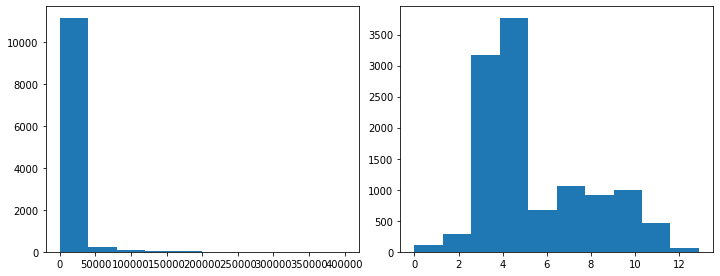

reply_count_total


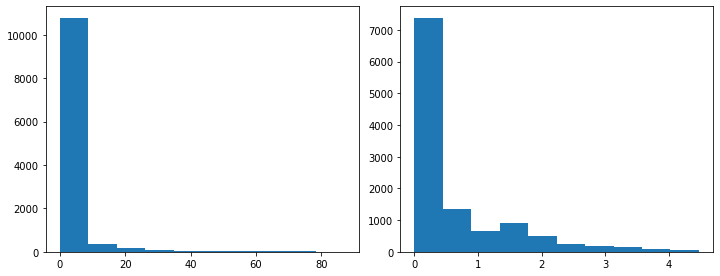

favorite_count_total


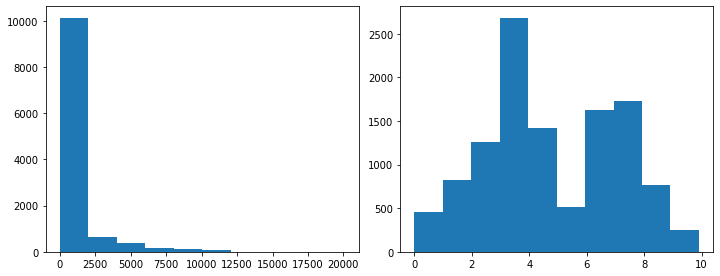

num_hashtags_total


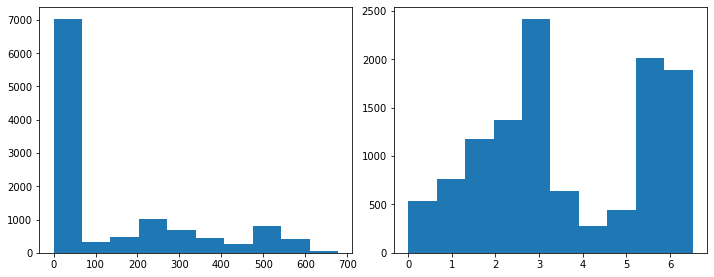

retweet_count_avg


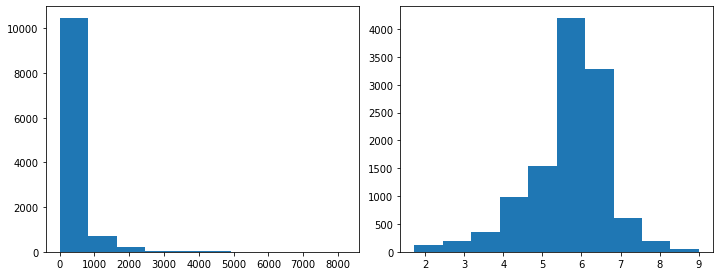

reply_count_avg


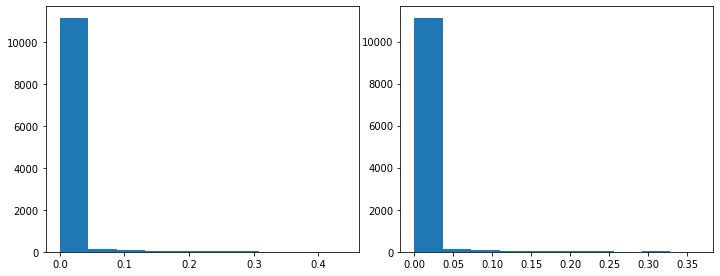

favorite_count_avg


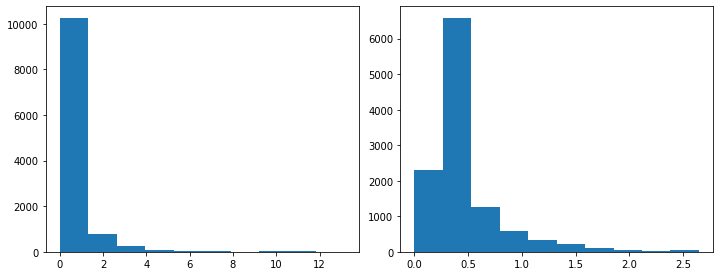

num_hashtags_avg


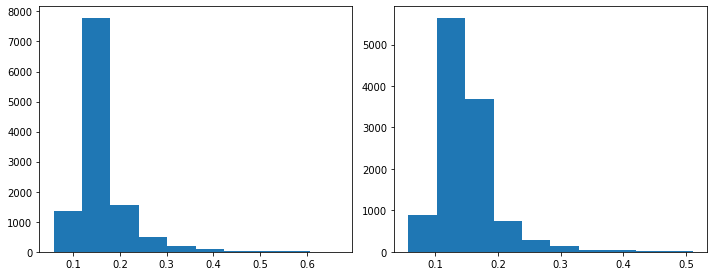

num_urls_avg


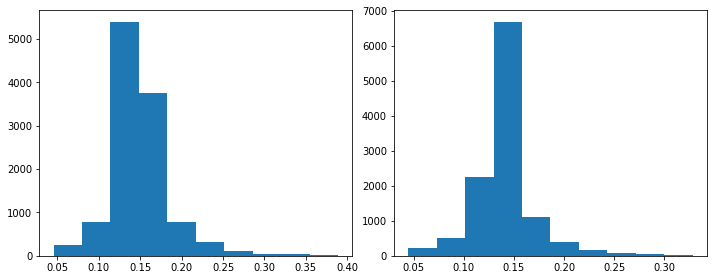

num_mentions_avg


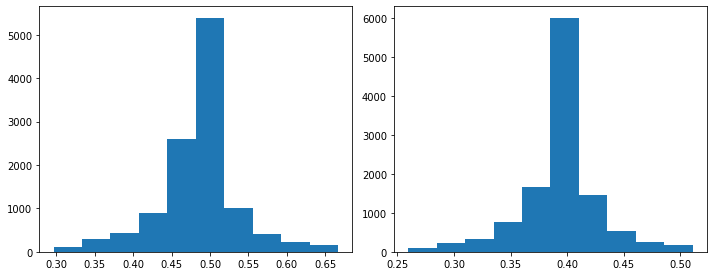

retweet_count_std


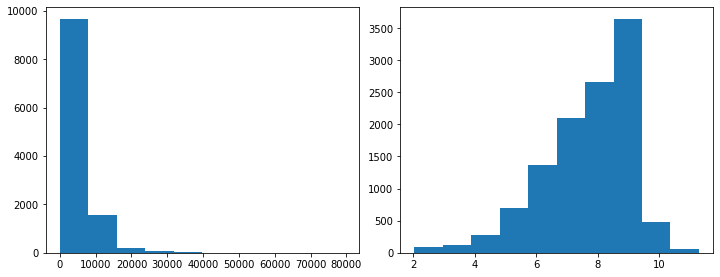

reply_count_std


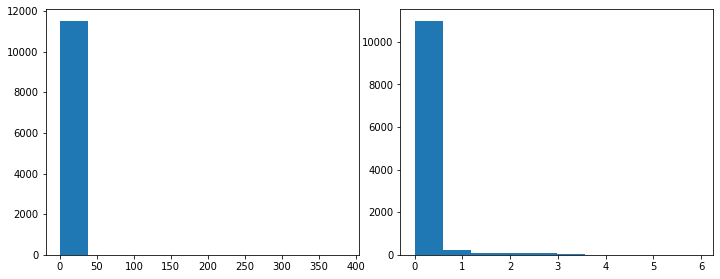

favorite_count_std


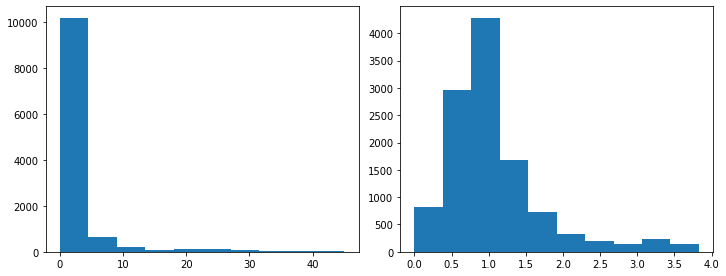

num_hashtags_std


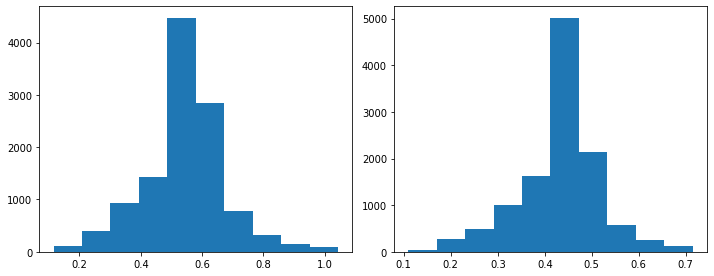

num_urls_std


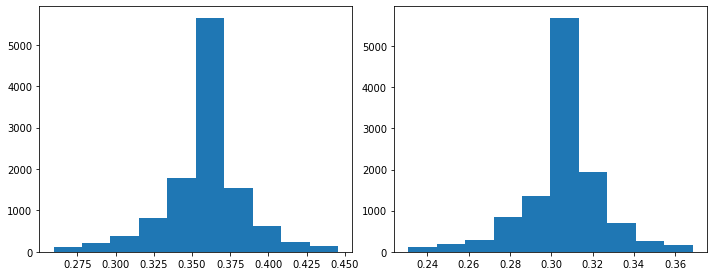

num_mentions_std


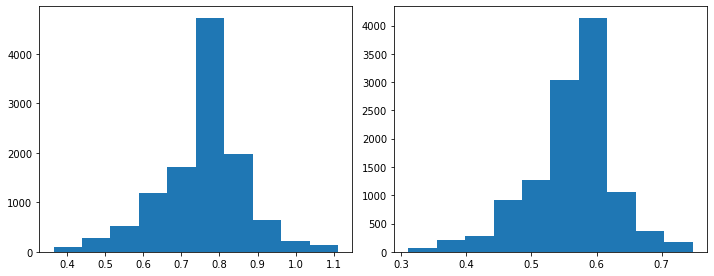

retweet_count_entropy


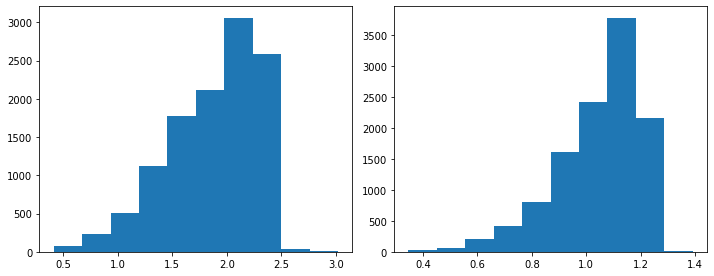

reply_count_entropy


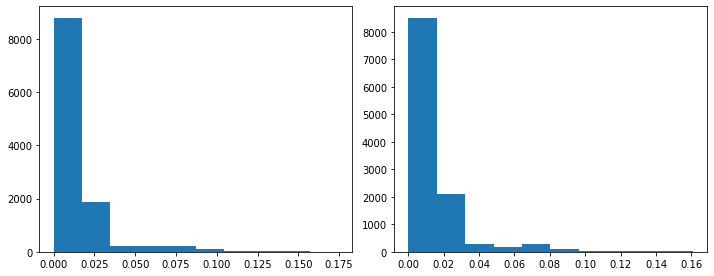

favorite_count_entropy


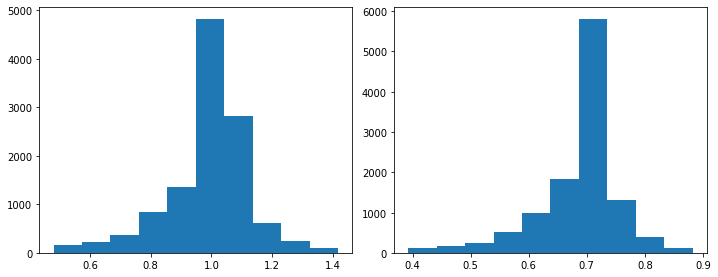

num_hashtags_entropy


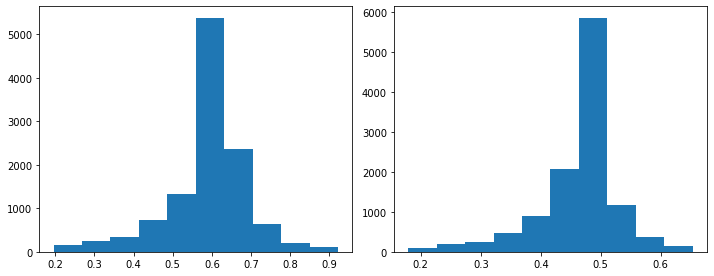

num_mentions_entropy


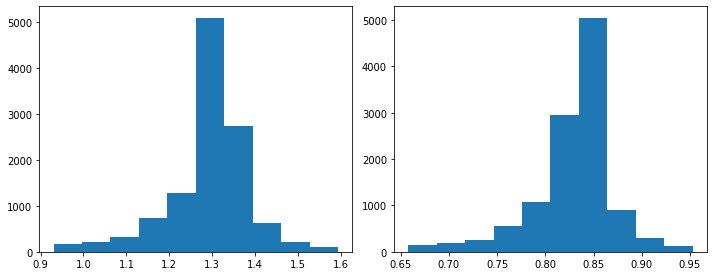

retweet_count_per_day


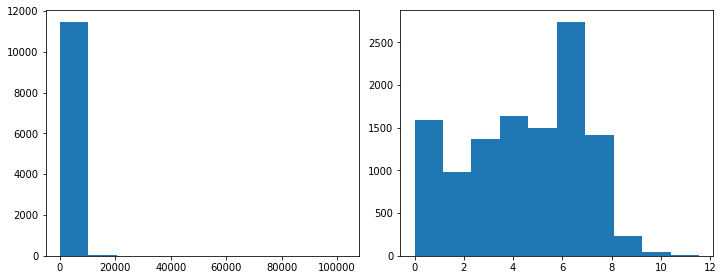

reply_count_per_day


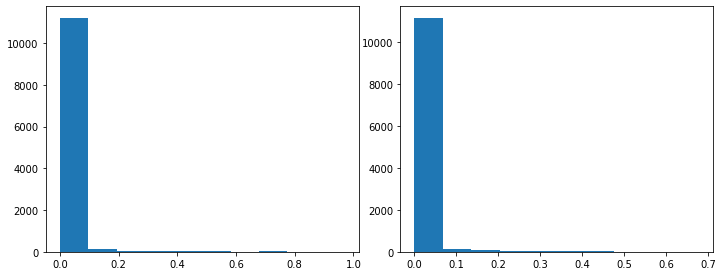

favorite_count_per_day


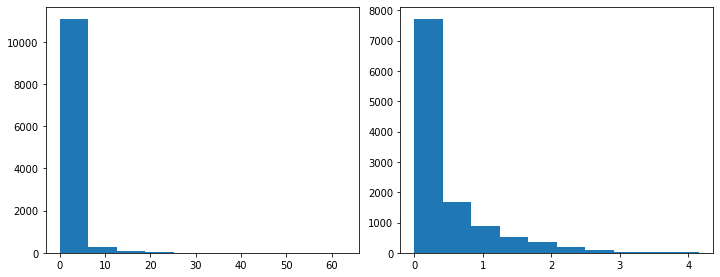

num_hashtags_per_day


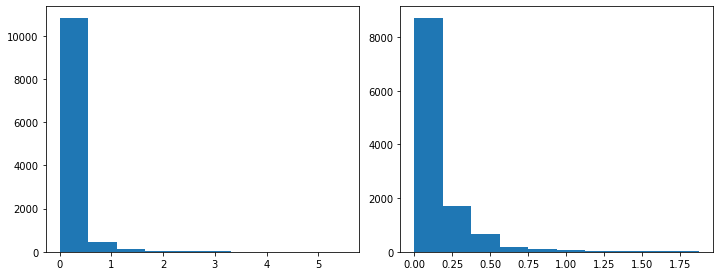

avg_len


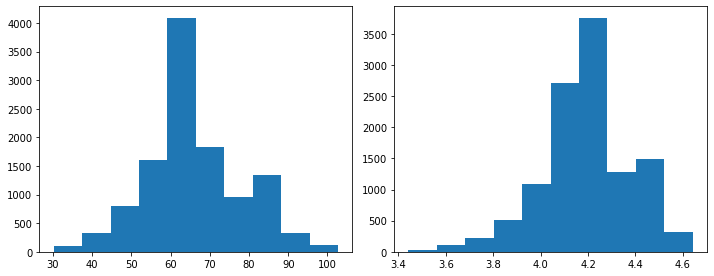

avg_spc_len


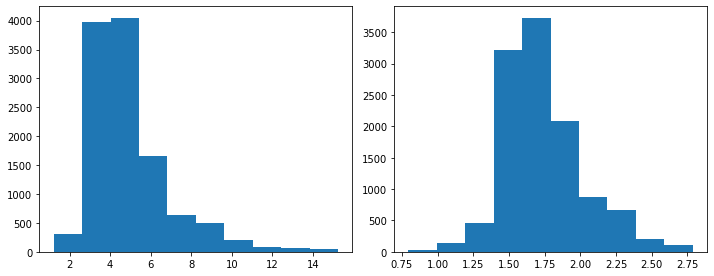

In [ ]:
for col in selected:
  print(col)
  vals = users_clustering[col]
  log_vals = users_clustering[col].apply(lambda x: np.log(x+1))
  fig, ax = plt.subplots(1, 2, figsize=(10,4))
  fig.tight_layout()
  ax[0].hist(vals, bins=10)
  ax[1].hist(log_vals, bins=10)
  plt.show()

In [ ]:
non_skewed_dists = [
  "avg_spc_len",
  "avg_len",
  "num_mentions_entropy",
  "num_hashtags_entropy",
  "favorite_count_entropy",
  "retweet_count_entropy",
  "num_mentions_std",
  "num_urls_std",
  "num_hashtags_std",
  "num_mentions_avg",
  "num_urls_avg"
]

In [ ]:
for col in selected:
  if col not in non_skewed_dists:
    print(col)
    data.loc[:, col] = data[col].apply(lambda x: np.log10(x+1))

statuses_count
reply_count_total
favorite_count_total
num_hashtags_total
retweet_count_avg
reply_count_avg
favorite_count_avg
num_hashtags_avg
retweet_count_std
reply_count_std
favorite_count_std
reply_count_entropy


/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


retweet_count_per_day
reply_count_per_day
favorite_count_per_day
num_hashtags_per_day


# Normalizing the data #

In [ ]:
method = "standard"

if method == "minmax":
  scaler = MinMaxScaler()
elif method == "standard":
  scaler = StandardScaler()

X = scaler.fit_transform(data.values)

# Utility functions



In [ ]:
def get_centers(X, labels):
  centers = []
  for val in np.sort(list(set(labels))):
    mask = labels == val
    cluster_data = X[mask,:]
    center = cluster_data.mean(axis=0)
    centers.append(center)
  return centers

def get_sse(labels, centers, X, K):
  sum = 0
  for k in range(K):
    datas = X[labels == k]
    center = centers[k]
    for data in datas:
      dist = np.linalg.norm(data - center)**2
      sum += dist
  return sum

# Euclidean distance

# Single linkage

<ipython-input-861-acd6f2622534>:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(1, 1, 1)


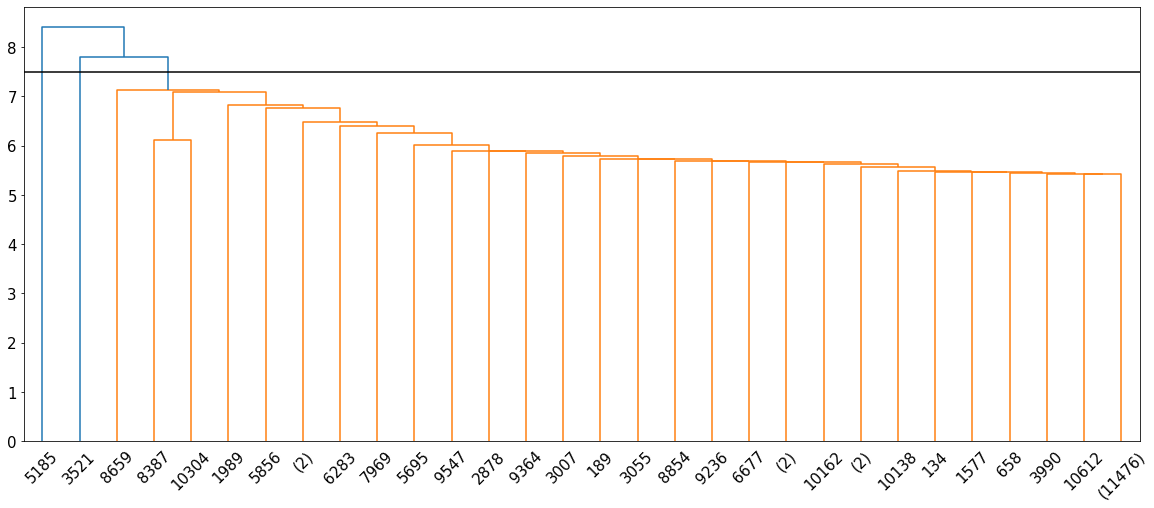

In [ ]:
data_dist = pdist(X, metric='euclidean')
data_link = linkage(data_dist, method='single', metric='euclidian')
y = 7.5

fig = plt.figure(figsize=(20,8))
plt.axhline(y = y, color = 'black', linestyle = '-')
ax = fig.add_subplot(1, 1, 1)
res = dendrogram(data_link, color_threshold=y, truncate_mode='lastp')
ax.tick_params(axis='x', which='major', labelsize=15)
ax.tick_params(axis='y', which='major', labelsize=15)



In [ ]:
n_clusters = 2
cluster = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='single')
cluster.fit_predict(X)


labels = cluster.labels_
centers = get_centers(X, labels)

print('SSE %s' % get_sse(labels, centers, X, n_clusters))
print('Silhouette %s' % silhouette_score(X, labels))
print('Separation %s' % metrics.davies_bouldin_score(X, labels))

SSE 310578.8759866549
Silhouette 0.45190406398009947
Separation 0.415533342991126


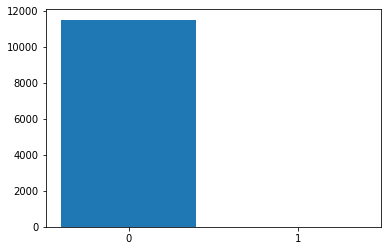

[11507     1]


In [ ]:
val, count = np.unique(labels, return_counts=True)
plt.bar(val, count)
plt.xticks(val)
plt.show()
print(count)

# Complete linkage

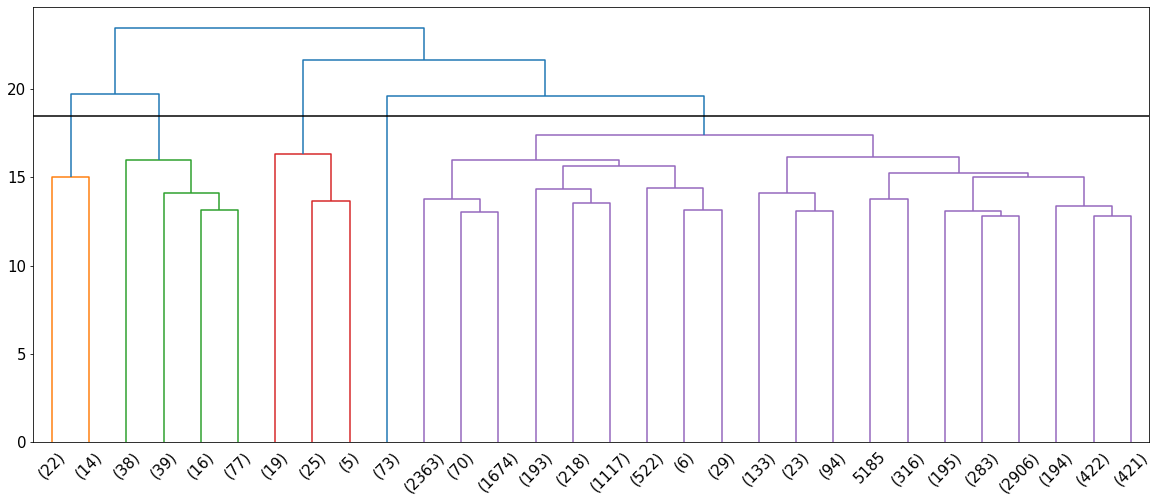

In [ ]:
data_dist = pdist(X, metric='euclidean')
data_link = linkage(data_dist, method='complete', metric='euclidian')
y = 18.5

fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(1, 1, 1)
plt.axhline(y = y, color = 'black', linestyle = '-')
res = dendrogram(data_link, color_threshold=y, truncate_mode='lastp')
ax.tick_params(axis='x', which='major', labelsize=15)
ax.tick_params(axis='y', which='major', labelsize=15)

In [ ]:
n_clusters = 5
cluster = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='complete')
cluster.fit_predict(X)


labels = cluster.labels_
centers = get_centers(X, labels)

print('SSE %s' % get_sse(labels, centers, X, n_clusters))
print('Silhouette %s' % silhouette_score(X, labels))
print('Separation %s' % metrics.davies_bouldin_score(X, labels))

SSE 278474.26560203946
Silhouette 0.3415913851708477
Separation 1.291180092196504


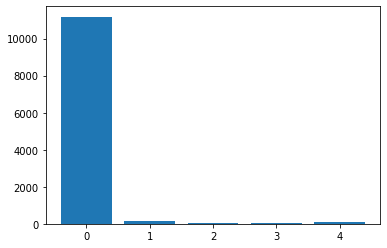

[11180   170    49    36    73]


In [ ]:
val, count = np.unique(labels, return_counts=True)
plt.bar(val, count)
plt.xticks(val)
plt.show()
print(count)

# Average linkage

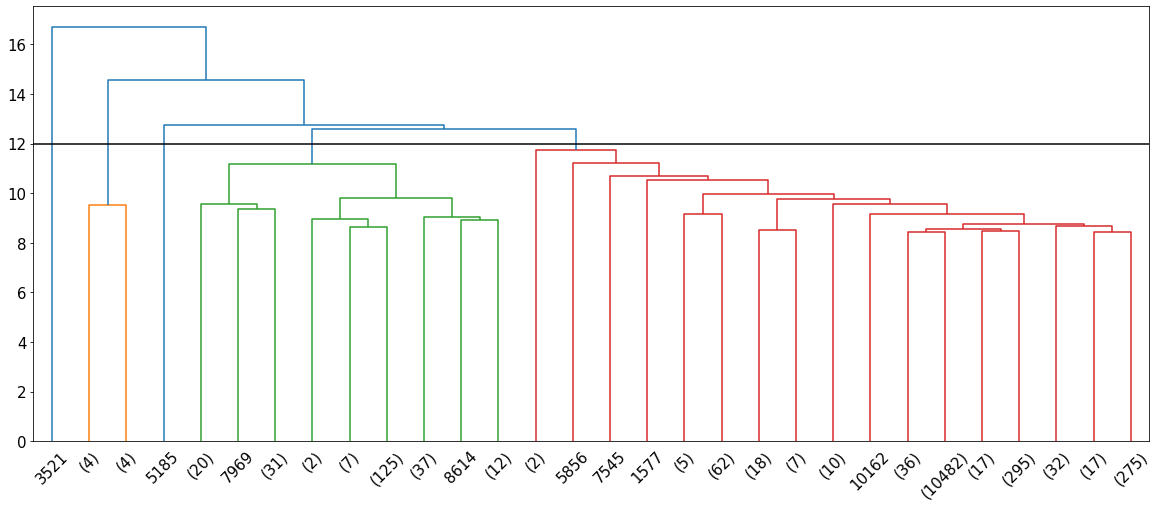

In [ ]:
data_dist = pdist(X, metric='euclidean')
data_link = linkage(data_dist, method='average', metric='euclidian')
y = 12

fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(1, 1, 1)
plt.axhline(y = y, color = 'black', linestyle = '-')
res = dendrogram(data_link, color_threshold=y, truncate_mode='lastp')
ax.tick_params(axis='x', which='major', labelsize=15)
ax.tick_params(axis='y', which='major', labelsize=15)

In [ ]:
n_clusters = 4
cluster = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='average')
cluster.fit_predict(X)


labels = cluster.labels_
centers = get_centers(X, labels)

print('SSE %s' % get_sse(labels, centers, X, n_clusters))
print('Silhouette %s' % silhouette_score(X, labels))
print('Separation %s' % metrics.davies_bouldin_score(X, labels))

SSE 309046.2336250873
Silhouette 0.43757111819291833
Separation 0.5923579470144886


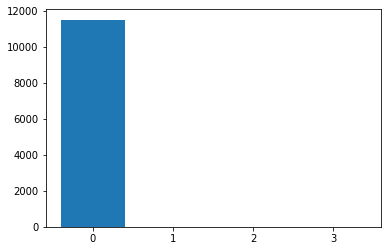

[11498     1     8     1]


In [ ]:
val, count = np.unique(labels, return_counts=True)
plt.bar(val, count)
plt.xticks(val)
plt.show()
print(count)

# Ward linkage

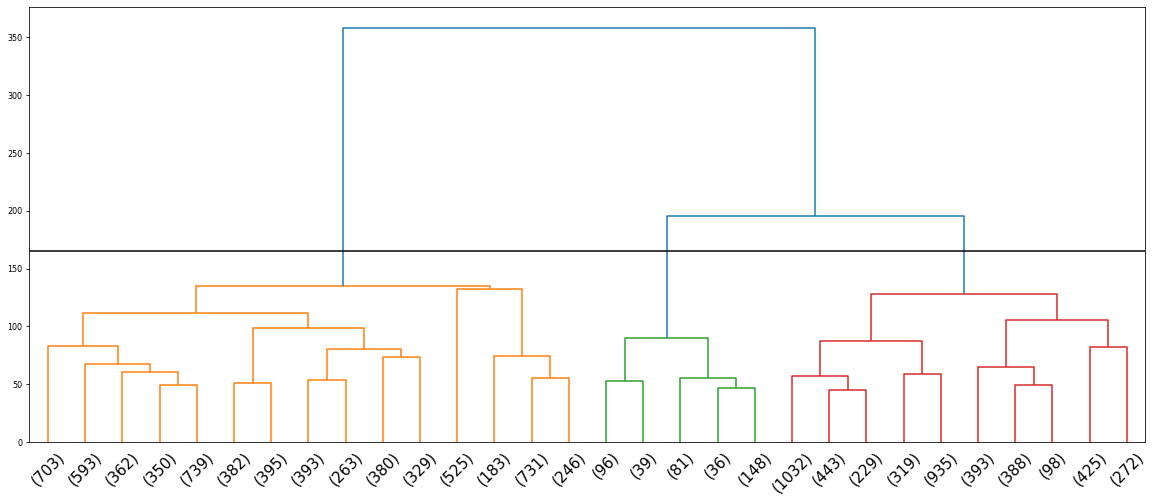

In [ ]:
data_dist = pdist(X, metric='euclidean')
data_link = linkage(data_dist, method='ward', metric='euclidian')
y = 165

fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(1, 1, 1)
plt.axhline(y = y, color = 'black', linestyle = '-')
res = dendrogram(data_link, color_threshold=y, truncate_mode='lastp')
ax.tick_params(axis='x', which='major', labelsize=15)
ax.tick_params(axis='y', which='major', labelsize=8)

In [ ]:
n_clusters = 3
cluster = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='ward')
cluster.fit_predict(X)


labels = cluster.labels_
centers = get_centers(X, labels)

print('SSE %s' % get_sse(labels, centers, X, n_clusters))
print('Silhouette %s' % silhouette_score(X, labels))
print('Separation %s' % metrics.davies_bouldin_score(X, labels))

SSE 227391.32026419314
Silhouette 0.19946400207137518
Separation 1.579789272056945


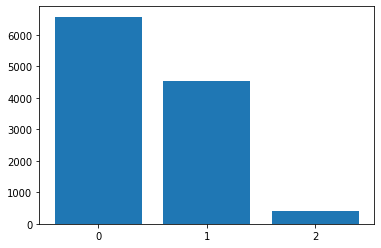

[6574 4534  400]


In [ ]:
val, count = np.unique(labels, return_counts=True)
plt.bar(val, count)
plt.xticks(val)
plt.show()
print(count)

# Cosine similarity

# Single linkage

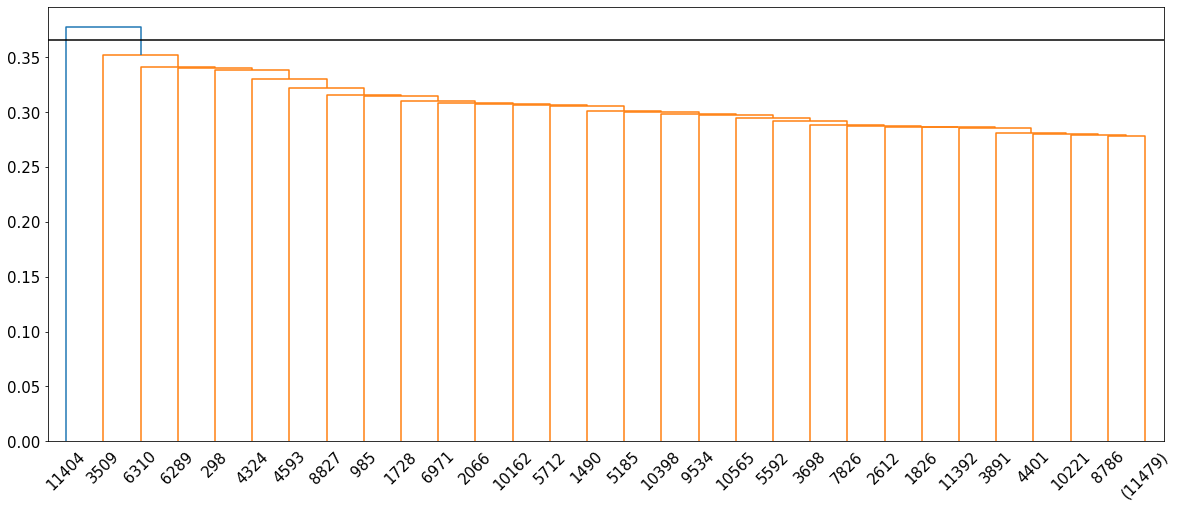

In [ ]:
data_dist = pdist(X, metric='cosine')
data_link = linkage(data_dist, method='single', metric='cosine')
y = 0.365

fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(1, 1, 1)
plt.axhline(y = y, color = 'black', linestyle = '-')
res = dendrogram(data_link, color_threshold=y, truncate_mode='lastp')
ax.tick_params(axis='x', which='major', labelsize=15)
ax.tick_params(axis='y', which='major', labelsize=15)

In [ ]:
n_clusters = 2
cluster = AgglomerativeClustering(n_clusters=n_clusters, affinity='cosine', linkage='single')
cluster.fit_predict(X)


labels = cluster.labels_
centers = get_centers(X, labels)

print('SSE %s' % get_sse(labels, centers, X, n_clusters))
print('Silhouette %s' % silhouette_score(X, labels))
print('Separation %s' % metrics.davies_bouldin_score(X, labels))

SSE 310684.7019452346
Silhouette 0.0808192360833464
Separation 0.8698680652796228


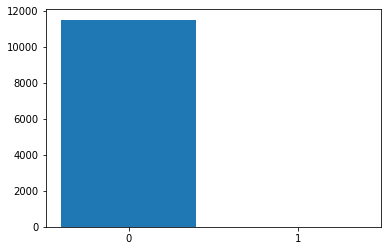

[11507     1]


In [ ]:
val, count = np.unique(labels, return_counts=True)
plt.bar(val, count)
plt.xticks(val)
plt.show()
print(count)

# Complete linkage

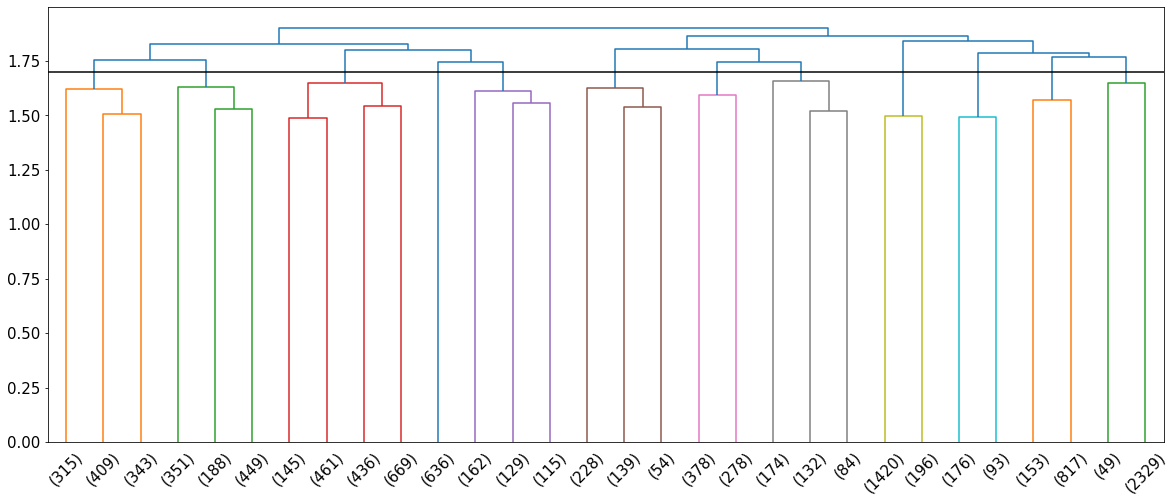

In [ ]:
data_dist = pdist(X, metric='cosine')
data_link = linkage(data_dist, method='complete', metric='cosine')
y = 1.7

fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(1, 1, 1)
plt.axhline(y = y, color = 'black', linestyle = '-')
res = dendrogram(data_link, color_threshold=y, truncate_mode='lastp')
ax.tick_params(axis='x', which='major', labelsize=15)
ax.tick_params(axis='y', which='major', labelsize=15)

In [ ]:
n_clusters = 12
cluster = AgglomerativeClustering(n_clusters=n_clusters, affinity='cosine', linkage='complete')
cluster.fit_predict(X)


labels = cluster.labels_
centers = get_centers(X, labels)

print('SSE %s' % get_sse(labels, centers, X, n_clusters))
print('Silhouette %s' % silhouette_score(X, labels))
print('Separation %s' % metrics.davies_bouldin_score(X, labels))

SSE 198843.93880139838
Silhouette 0.01770889776346285
Separation 2.7410291458855984


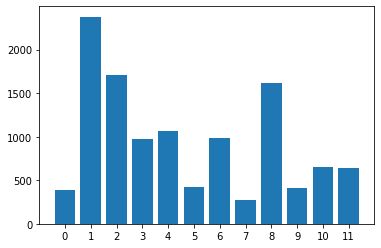

[ 390 2378 1711  970 1067  421  988  269 1616  406  656  636]


In [ ]:
val, count = np.unique(labels, return_counts=True)
plt.bar(val, count)
plt.xticks(val)
plt.show()
print(count)

# Average linkage

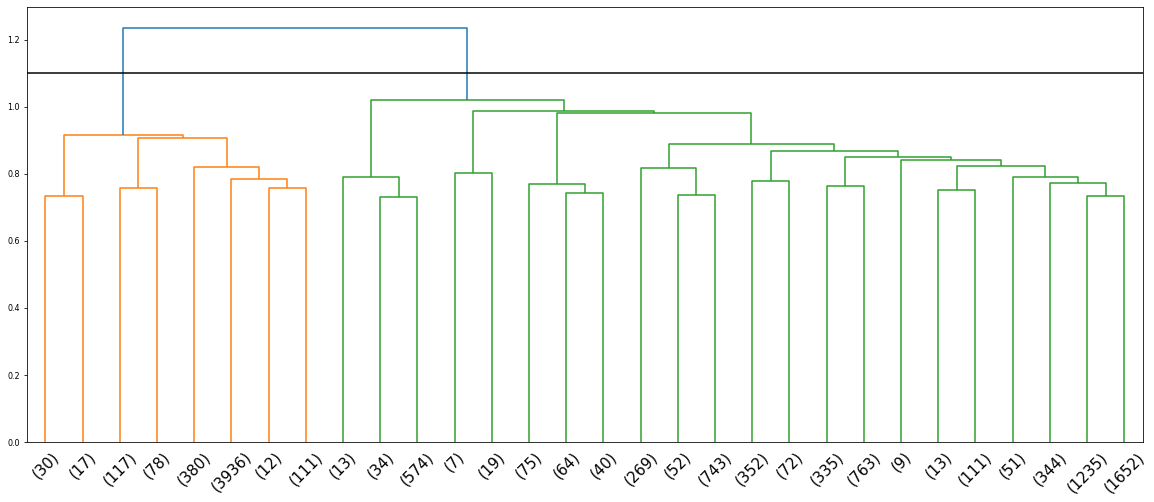

In [ ]:
data_dist = pdist(X, metric='cosine')
data_link = linkage(data_dist, method='average', metric='cosine')
y = 1.1

fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(1, 1, 1)
plt.axhline(y = y, color = 'black', linestyle = '-')
res = dendrogram(data_link, color_threshold=y, truncate_mode='lastp')
ax.tick_params(axis='x', which='major', labelsize=15)
ax.tick_params(axis='y', which='major', labelsize=8)

In [ ]:
n_clusters = 2
cluster = AgglomerativeClustering(n_clusters=n_clusters, affinity='cosine', linkage='average')
cluster.fit_predict(X)


labels = cluster.labels_
centers = get_centers(X, labels)

print('SSE %s' % get_sse(labels, centers, X, n_clusters))
print('Silhouette %s' % silhouette_score(X, labels))
print('Separation %s' % metrics.davies_bouldin_score(X, labels))

SSE 246347.18755261909
Silhouette 0.2045842500497779
Separation 1.7500006261744545


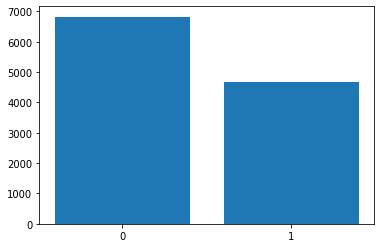

[6827 4681]


In [ ]:
val, count = np.unique(labels, return_counts=True)
plt.bar(val, count)
plt.xticks(val)
plt.show()
print(count)

# Execute the algorithm with the selected metric and linkage (eucildean and ward)

In [ ]:
metric = "euclidean"
linkage = "ward"
n_clusters = 3


cluster = AgglomerativeClustering(n_clusters=n_clusters, affinity=metric, linkage=linkage)
cluster.fit_predict(X)


labels = cluster.labels_
norm_centers = get_centers(X, labels)
centers = scaler.inverse_transform(norm_centers)

# Visualize clusters in 2D

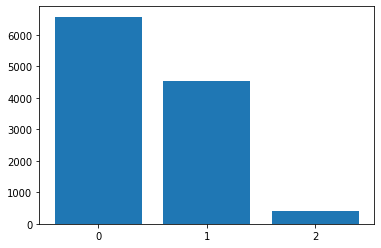

[6574 4534  400]


In [ ]:
val, count = np.unique(labels, return_counts=True)
plt.bar(val, count)
plt.xticks(val)
plt.show()
print(count)

# Visualize clusters in 2D

In [ ]:
def plot_2d_proj(attr1, attr2):

  colors = plt.cm.jet(np.linspace(0,1,len(set(labels))))

  for label in set(labels):
    x = data[attr1][labels == label]
    y = data[attr2][labels == label]
    color = labels[labels == label]
    plt.xlabel(attr1)
    plt.ylabel(attr2)
    plt.scatter(x, y, c=np.array([colors[label]]), label=str(label))
  plt.legend()
  plt.show()

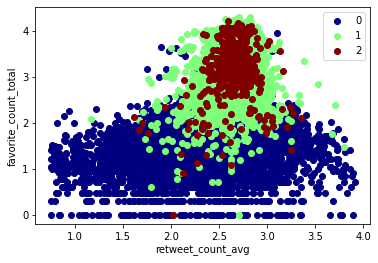

In [ ]:
plot_2d_proj("retweet_count_avg", "favorite_count_total")

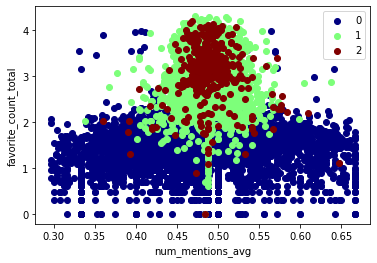

In [ ]:
plot_2d_proj("num_mentions_avg", "favorite_count_total")

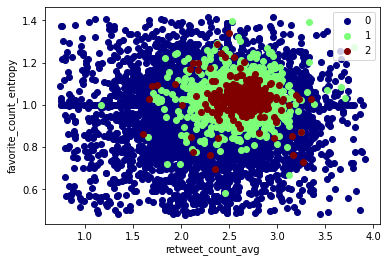

In [ ]:
plot_2d_proj("retweet_count_avg", "favorite_count_entropy")

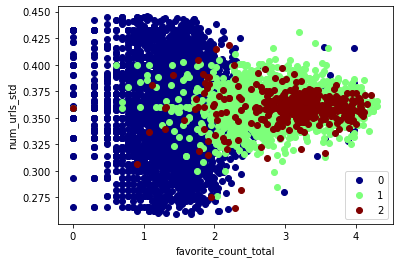

In [ ]:
plot_2d_proj("favorite_count_total", "num_urls_std")

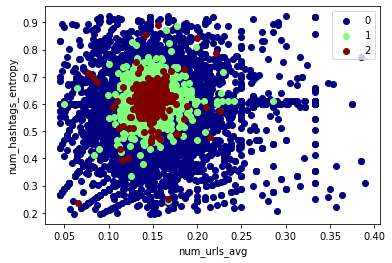

In [ ]:
plot_2d_proj("num_urls_avg", "num_hashtags_entropy")

# Visualize with PCA #

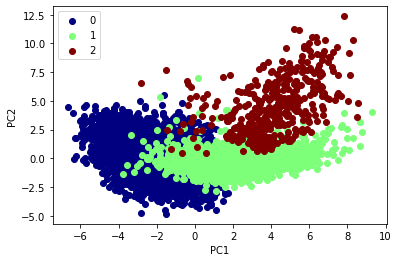

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

X_pca = pca.fit_transform(X)
X_pca.shape


colors = plt.cm.jet(np.linspace(0,1,len(set(labels))))

for label in set(labels):
  mask = labels == label
  x = X_pca[mask, 0]
  y = X_pca[mask, 1]
  color = labels[labels == label]
  plt.xlabel("PC1")
  plt.ylabel("PC2")
  plt.scatter(x, y, c=np.array([colors[label]]), label=str(label))
plt.legend()
plt.show()

# Cluster validation 

In [ ]:
val, count = np.unique(labels, return_counts=True)

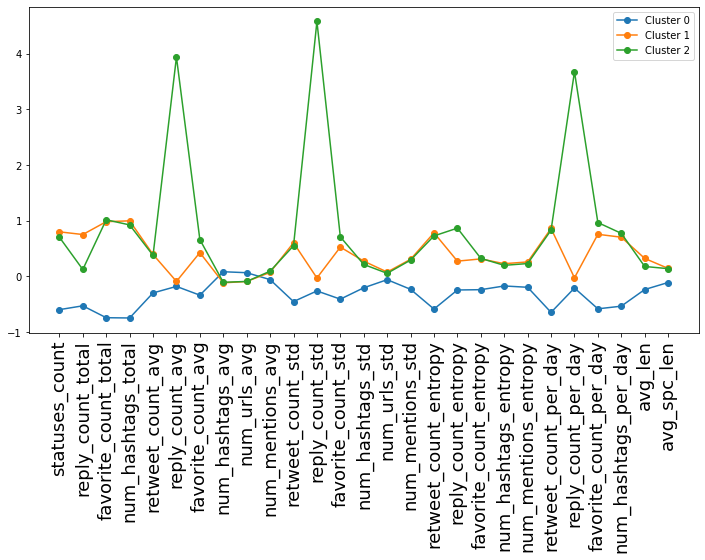

In [ ]:
plt.figure(figsize=(12, 6))
for i in range(0, len(centers)):
  plt.plot(norm_centers[i], marker='o', label='Cluster %s' % i)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.xticks(range(0, len(data.columns)), data.columns, fontsize=18, rotation=90)
plt.legend(fontsize=10)
plt.show()

<ipython-input-893-6dc99a9efba8>:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(polar=True)


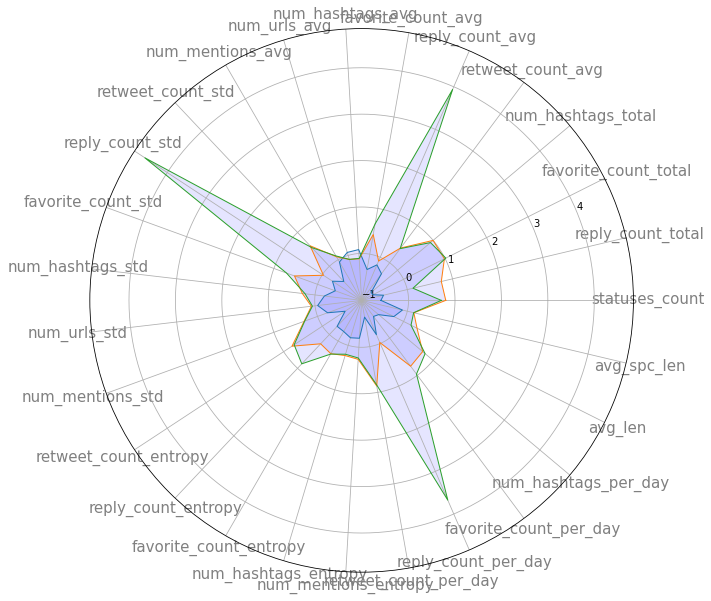

In [ ]:
from math import pi

 
# number of variable
fig = plt.figure(figsize=(10, 10))
N = len(data.columns)
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
for i in range(0, len(centers)):
  angles = [n / float(N) * 2 * pi for n in range(N)]
  values = norm_centers[i].tolist()
  values += values[:1]
  angles += angles[:1]
# Initialise the spider plot
  ax = plt.subplot(polar=True)
# Draw one axe per variable + add labels labels yet
  plt.xticks(angles[:-1], data.columns, color='grey', size=15) 
# Plot data

  ax.plot(angles, values, linewidth=1, linestyle='solid')
# Fill area
  ax.fill(angles, values, 'b', alpha=0.1)


In [ ]:
from sklearn import metrics
print('SSE %s' % get_sse(labels, norm_centers, X, n_clusters))
print('Silhouette %s' % silhouette_score(X, labels))
print('Separation %s' % metrics.davies_bouldin_score(X, labels))


SSE 227391.32026419314
Silhouette 0.19946400207137518
Separation 1.579789272056945


# Compute median stats for each cluster
For each cluster we compute the median value of the attribute for the users of that cluster. The results are shown in the following tables (last row has the median values computed over the all dataset)

In [ ]:
def print_median_stats(selected_cols, labels):
  means_dict = {}

  means_dict["num_users"] = []
  for i in range(0, n_clusters):
    data = len(users.iloc[labels == i]["id"])
    means_dict["num_users"].append(data)
  data = len(users.iloc[:]["id"])
  means_dict["num_users"].append(data)


  for col in selected_cols:
    means_dict[col] = []
    for i in range(0, n_clusters):
      data = users.iloc[labels == i][col]
      median = data.median()
      means_dict[col].append(median)

    data = users.iloc[:][col]
    median = data.median()
    means_dict[col].append(median)  

  means_dict["bots_frac"] = []
  for i in range(0, n_clusters):
    data = users.iloc[labels == i]["bot"]
    means_dict["bots_frac"].append(data.mean())
  data = users.iloc[:]["bot"]
  means_dict["bots_frac"].append(data.mean())

  means_dict["mode_lang"] = []
  for i in range(0, n_clusters):
    data = users.iloc[labels == i][["id", "lang"]].groupby("lang", as_index=False).count()
    lang = data[data["lang"] != "en"].sort_values(by= "id", ascending=False).iloc[0]["lang"]
    means_dict["mode_lang"].append(lang)
  data = users.iloc[:][["id", "lang"]].groupby("lang", as_index=False).count()
  lang = data[data["lang"] != "en"].sort_values(by= "id", ascending=False).iloc[0]["lang"]
  means_dict["mode_lang"].append(lang)

  means_df = pd.DataFrame(means_dict)
  return means_df.head(n_clusters+1)

In [ ]:
# selected_cols = users.columns[5:]  

selected_cols = [
    "statuses_count",
    "num_tweets",
    "retweet_count_total",
    "reply_count_total",
    "favorite_count_total",
    "retweet_count_avg",
    "reply_count_avg",
    "favorite_count_avg",
    "retweet_count_per_day",
    "reply_count_per_day",
    "favorite_count_per_day",
    "retweet_count_std",
    "reply_count_std",
    "favorite_count_std",
]

med_stats = print_median_stats(selected_cols, labels)
med_stats

,num_users,statuses_count,num_tweets,retweet_count_total,reply_count_total,favorite_count_total,retweet_count_avg,reply_count_avg,favorite_count_avg,retweet_count_per_day,reply_count_per_day,favorite_count_per_day,retweet_count_std,reply_count_std,favorite_count_std,bots_frac,mode_lang
0,6574,46.0,84.0,11391.5,0.0,28.0,156.094532,0.000000,0.368211,19.948177,0.000000,0.053303,801.997755,0.000000,1.053898,0.677974,es
1,4534,2177.5,1799.5,884885.5,3.0,1161.5,460.547493,0.001804,0.521375,720.819788,0.002921,1.036475,5976.021477,0.045462,3.549067,0.333480,it
2,400,2159.0,2128.5,1010956.5,247.0,1546.0,453.783386,0.148808,0.680275,750.180186,0.242337,1.308107,5987.531099,5.277852,7.680123,0.367500,it
3,11508,64.0,124.0,62117.5,0.0,64.0,342.088059,0.000000,0.452446,114.989442,0.000000,0.133843,2906.034035,0.000000,1.709396,0.531456,it


In [ ]:

selected_cols = [ 
    "avg_len",
    "avg_spc_len",
    "tweets_per_day",
    "num_hashtags_total",
    "num_mentions_total",
    "num_urls_total",
    "num_hashtags_avg",
    "num_mentions_avg",
    "num_urls_avg",
    "num_hashtags_per_day",
    "num_mentions_per_day",
    "num_urls_per_day",
    "num_hashtags_std",
    "num_mentions_std",
    "num_urls_std",
]

med_stats = print_median_stats(selected_cols, labels)
med_stats

,num_users,avg_len,avg_spc_len,tweets_per_day,num_hashtags_total,num_mentions_total,num_urls_total,num_hashtags_avg,num_mentions_avg,num_urls_avg,num_hashtags_per_day,num_mentions_per_day,num_urls_per_day,num_hashtags_std,num_mentions_std,num_urls_std,bots_frac,mode_lang
0,6574,63.529923,4.081764,0.191624,10.0,38.0,11.0,0.142857,0.481481,0.142857,0.018605,0.080892,0.021327,0.476565,0.710907,0.351333,0.677974,es
1,4534,76.524103,5.294268,1.445173,285.0,876.0,265.0,0.157690,0.488095,0.147239,0.229355,0.702793,0.214515,0.581366,0.790953,0.360351,0.333480,it
2,400,69.987148,4.724026,1.525128,344.0,1049.5,317.0,0.157153,0.487354,0.147546,0.240189,0.760053,0.228126,0.575795,0.791132,0.360287,0.367500,it
3,11508,64.978620,4.598511,0.279176,21.0,62.0,19.0,0.154930,0.486671,0.146271,0.046296,0.138742,0.041860,0.553269,0.770949,0.358643,0.531456,it


In [ ]:
data = users.iloc[labels == 1][["id", "lang"]].groupby("lang", as_index=False).count()
lang = data[data["lang"] != "en"].sort_values(by= "id", ascending=False).iloc[0]["lang"]
lang

'it'

# Bots distribution per cluster

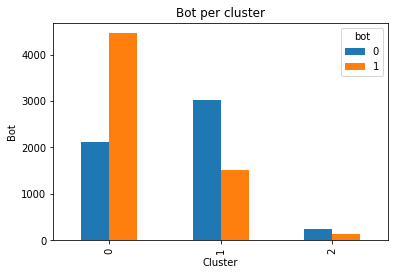

In [ ]:
bot_xt_pct = pd.crosstab(labels, users['bot'])
bot_xt_pct.plot(kind='bar', stacked=False, title='Bot per cluster')
plt.xlabel('Cluster')
plt.ylabel('Bot')
plt.show()

# Languages distribution per cluster

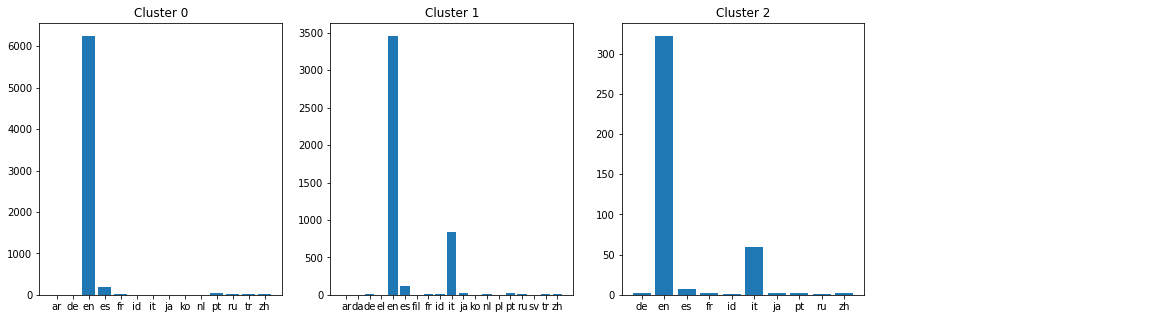

In [ ]:
data_list = []

for i in range(0, n_clusters):
  accounts = users.iloc[labels == i][["id", "lang"]].groupby("lang").count().to_dict()["id"]
  data_list.append((accounts.keys(), accounts.values()))

plot_bar_grid(data_list, figsize=figsize)

# Languages distribution per cluster (excluding english)

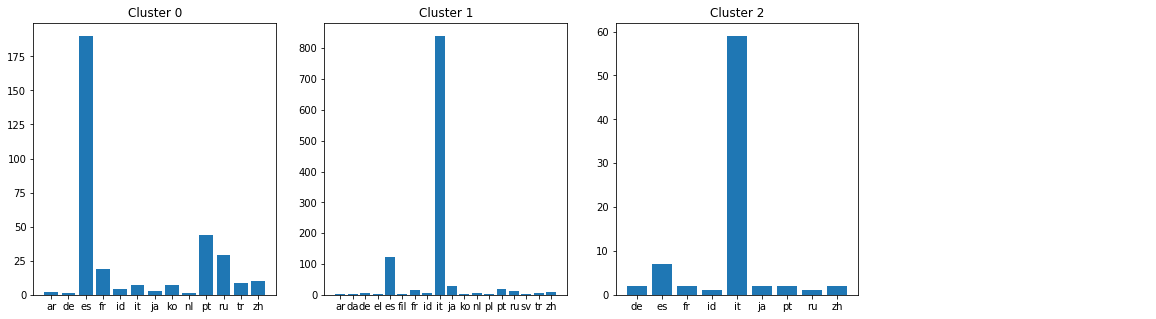

In [ ]:
data_list = []

for i in range(0, n_clusters):
  accounts = users.iloc[labels == i][["id", "lang"]].groupby("lang").count().to_dict()["id"]
  del accounts["en"]
  data_list.append((accounts.keys(), accounts.values()))

plot_bar_grid(data_list, figsize=figsize)

# Created at distribution per cluster

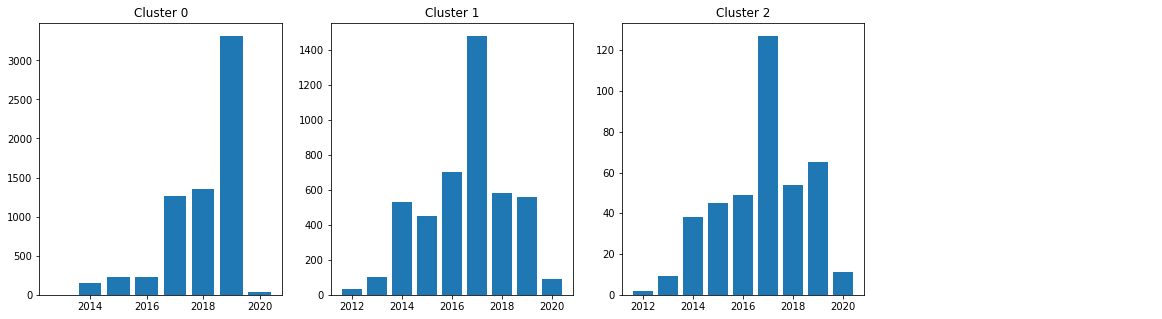

In [ ]:
col = "created_at"

users[col] = pd.to_datetime(users[col])
data_list = []

for i in range(0, n_clusters):
  accounts = users.iloc[labels == i][[col]].groupby(users[col].dt.year).count().to_dict()[col]
  data_list.append((accounts.keys(), accounts.values()))

plot_bar_grid(data_list, figsize=figsize)

# Log transformation to skewed features

In [ ]:
for col in selected:
  if col not in non_skewed_dists:
    print(col)
    users.loc[:, col] = users[col].apply(lambda x: np.log10(x+1))

statuses_count
reply_count_total
favorite_count_total
num_hashtags_total
retweet_count_avg
reply_count_avg
favorite_count_avg
num_hashtags_avg
retweet_count_std
reply_count_std
favorite_count_std
reply_count_entropy
retweet_count_per_day
reply_count_per_day
favorite_count_per_day
num_hashtags_per_day


# Statuses count distribution per cluster

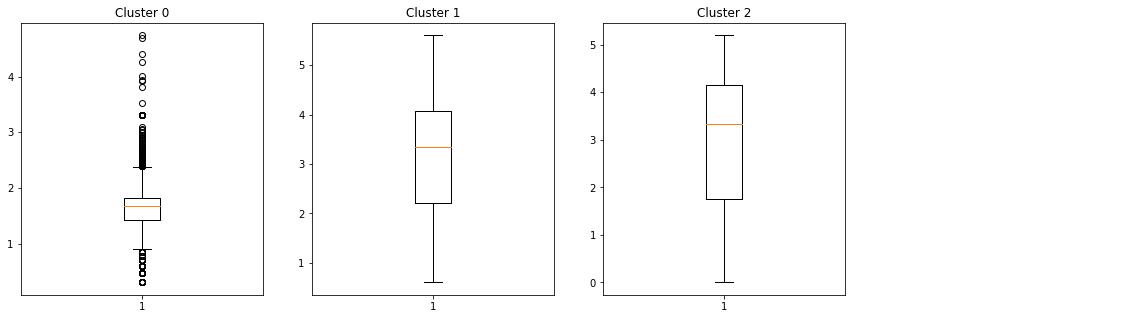

In [ ]:
col = "statuses_count"
data_list = []

for i in range(0, n_clusters):
  accounts = users.iloc[labels == i][col]
  data_list.append(accounts)

plot_boxplot_grid(data_list, figsize=figsize)

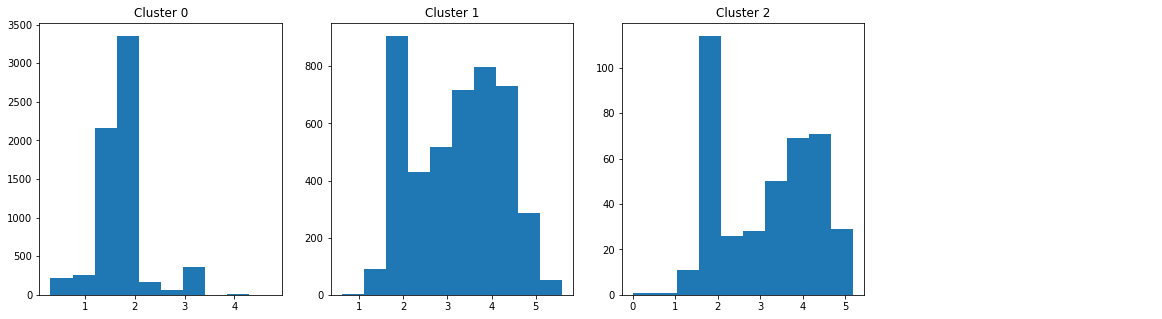

In [ ]:
data_list = []

for i in range(0, n_clusters):
  accounts = users.iloc[labels == i][col]
  data_list.append(accounts)

plot_hist_grid(data_list, figsize=figsize, n_bins=10)

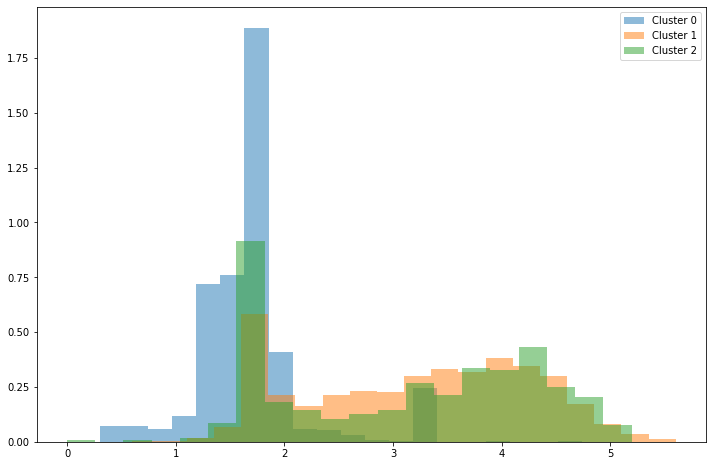

In [ ]:
data_list = []

for i in range(0, n_clusters):
  accounts = users.iloc[labels == i][col]
  data_list.append(accounts)


print_overlapping_histograms(data_list)

# Tweet numbers distribution per cluster

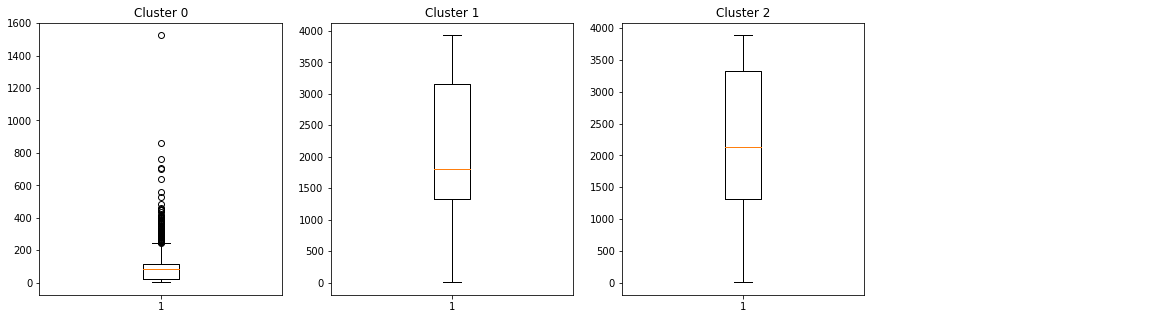

In [ ]:
col = "num_tweets"
data_list = []

for i in range(0, n_clusters):
  accounts = users.iloc[labels == i][col]
  data_list.append(accounts)

plot_boxplot_grid(data_list, figsize=figsize)

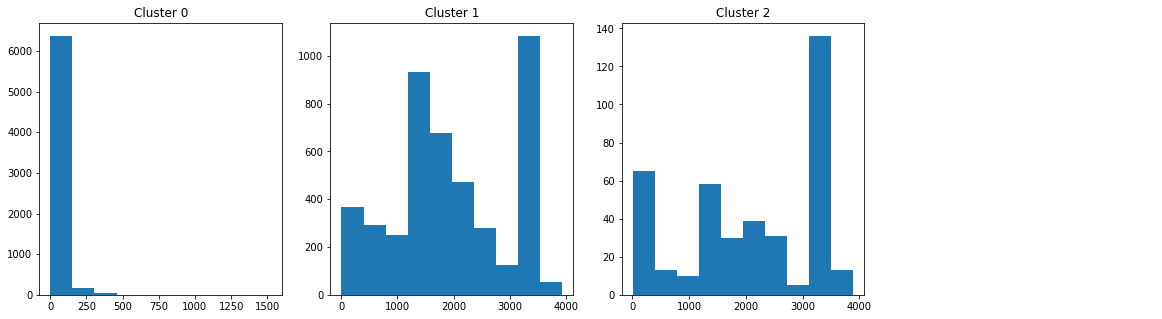

In [ ]:
data_list = []

for i in range(0, n_clusters):
  accounts = users.iloc[labels == i][col]
  data_list.append(accounts)

plot_hist_grid(data_list, n_bins=10, figsize=figsize)

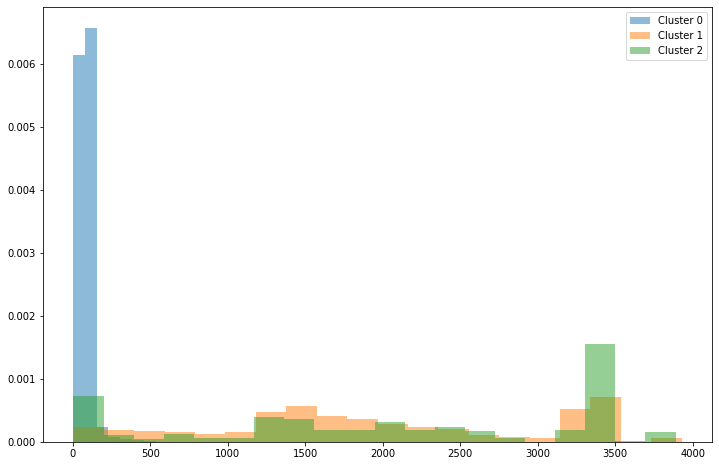

In [ ]:
data_list = []

for i in range(0, n_clusters):
  accounts = users.iloc[labels == i][col]
  data_list.append(accounts)


print_overlapping_histograms(data_list)

# Retweet count total distribution per cluster

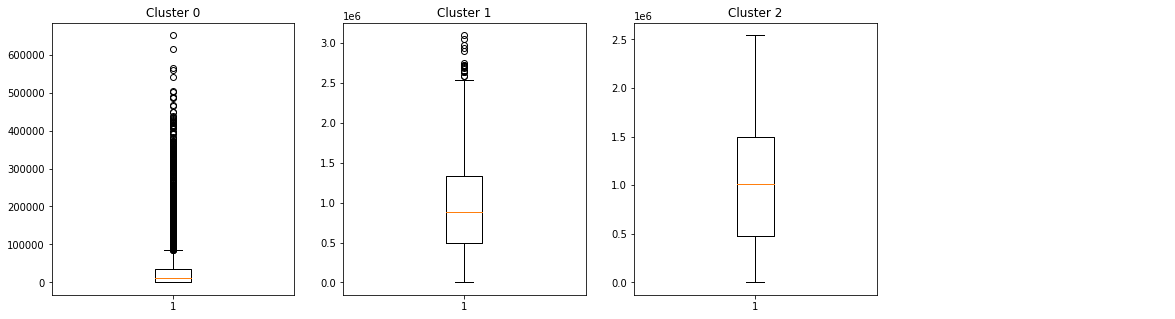

In [ ]:
col = "retweet_count_total"
data_list = []

for i in range(0, n_clusters):
  accounts = users.iloc[labels == i][col]
  data_list.append(accounts)

plot_boxplot_grid(data_list, figsize=figsize)

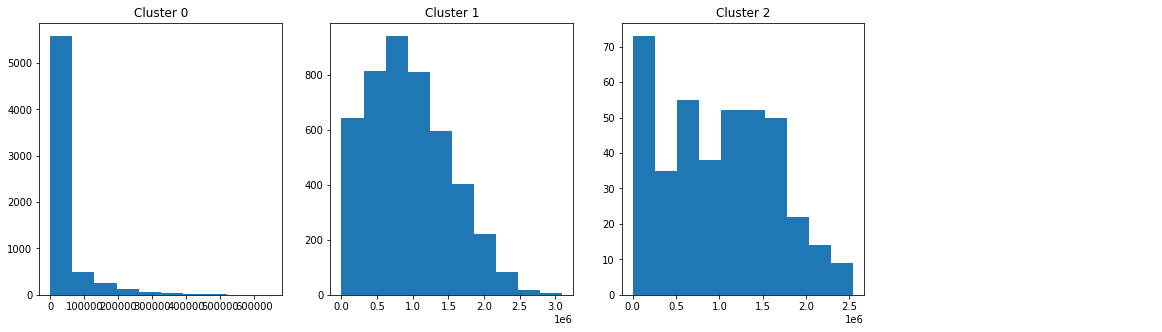

In [ ]:
data_list = []

for i in range(0, n_clusters):
  accounts = users.iloc[labels == i][col]
  data_list.append(accounts)

plot_hist_grid(data_list, n_bins=10, figsize=figsize)

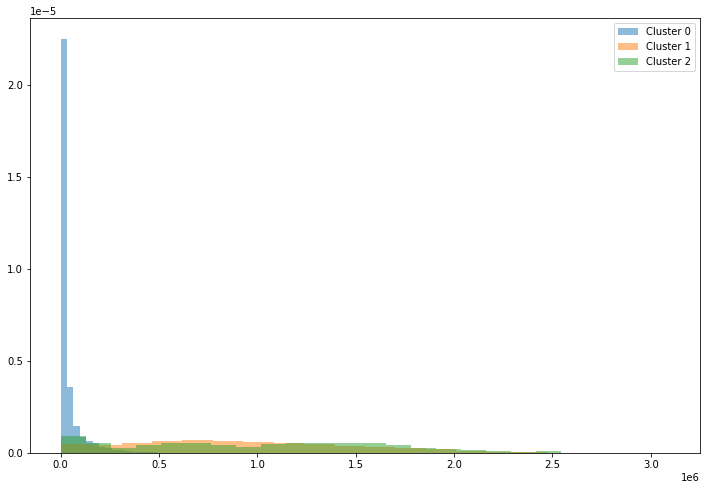

In [ ]:
data_list = []

for i in range(0, n_clusters):
  accounts = users.iloc[labels == i][col]
  data_list.append(accounts)


print_overlapping_histograms(data_list)

# Reply count total distribution per cluster

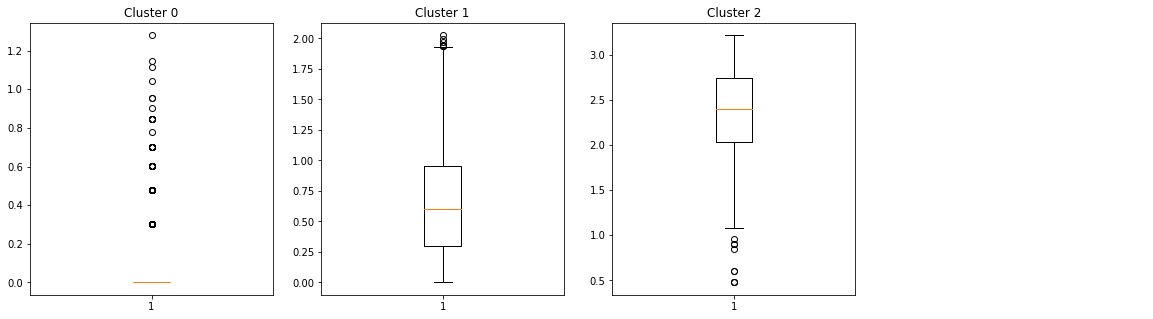

In [ ]:
col = "reply_count_total"
data_list = []

for i in range(0, n_clusters):
  accounts = users.iloc[labels == i][col]
  data_list.append(accounts)

plot_boxplot_grid(data_list, figsize=figsize)

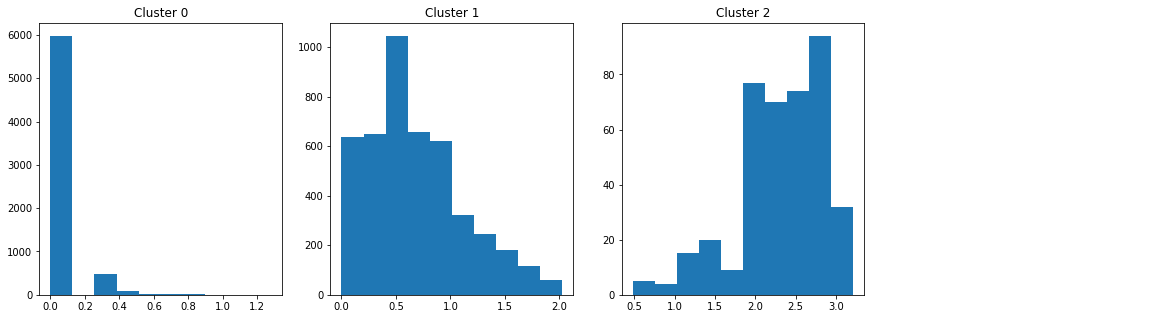

In [ ]:
data_list = []

for i in range(0, n_clusters):
  accounts = users.iloc[labels == i][col]
  data_list.append(accounts)

plot_hist_grid(data_list, n_bins=10, figsize=figsize)

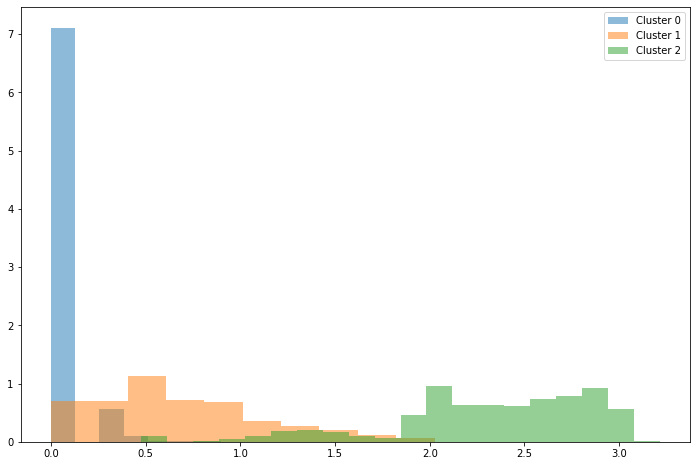

In [ ]:
data_list = []

for i in range(0, n_clusters):
  accounts = users.iloc[labels == i][col]
  data_list.append(accounts)


print_overlapping_histograms(data_list, [10, 10, 20])

# Favorite count total distribution per cluster

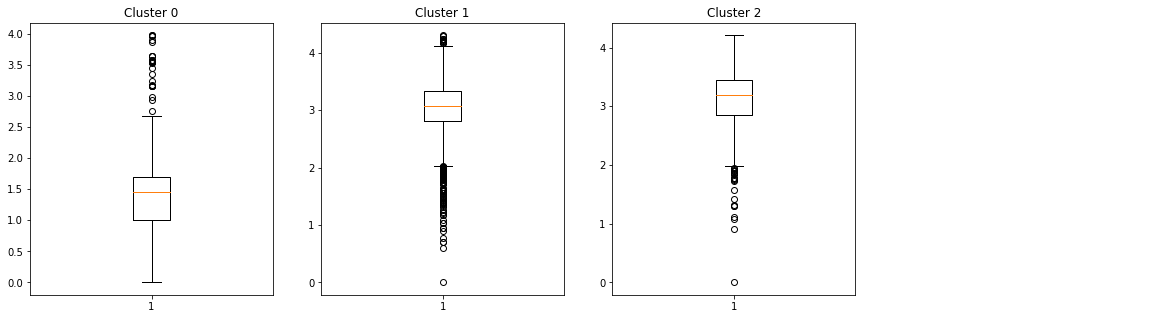

In [ ]:
col = "favorite_count_total"
data_list = []

for i in range(0, n_clusters):
  accounts = users.iloc[labels == i][col]
  data_list.append(accounts)

plot_boxplot_grid(data_list, figsize=figsize)

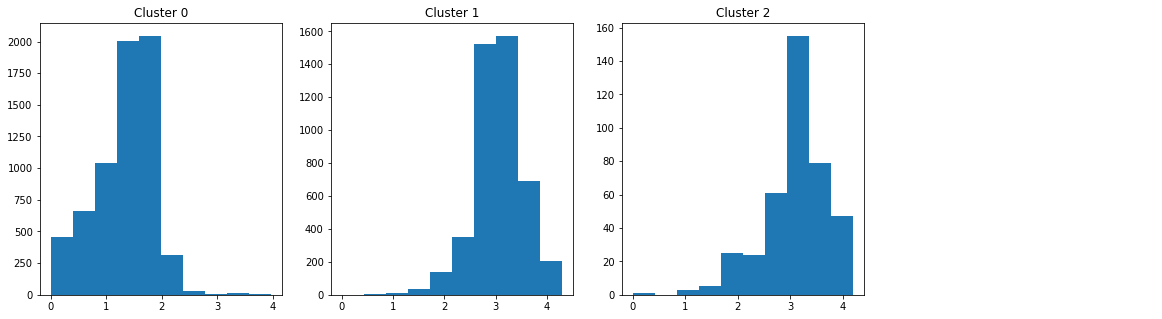

In [ ]:
data_list = []

for i in range(0, n_clusters):
  accounts = users.iloc[labels == i][col]
  data_list.append(accounts)

plot_hist_grid(data_list, n_bins=10, figsize=figsize)

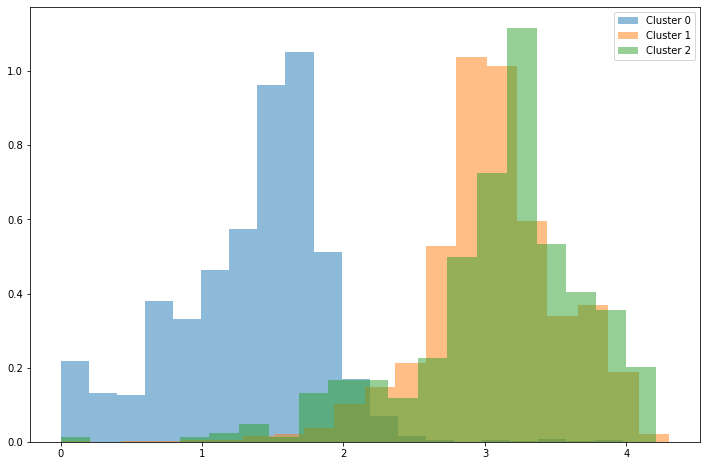

In [ ]:
data_list = []

for i in range(0, n_clusters):
  accounts = users.iloc[labels == i][col]
  data_list.append(accounts)


print_overlapping_histograms(data_list)

# Hashtags number total distribution per cluster

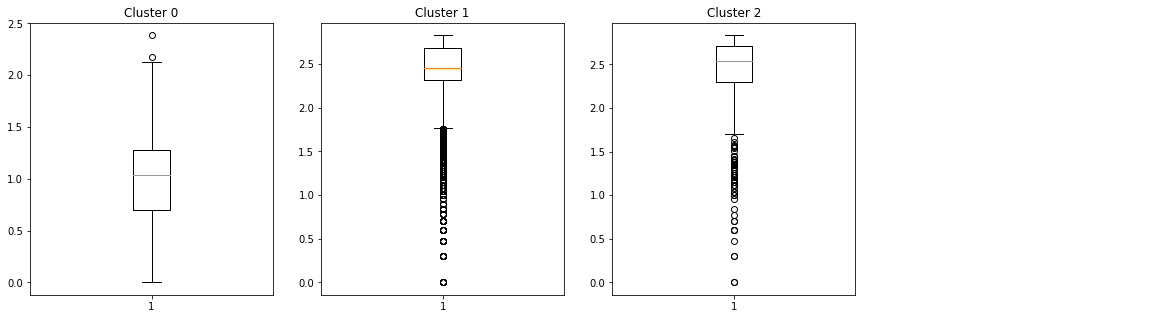

In [ ]:
col = "num_hashtags_total"
data_list = []

for i in range(0, n_clusters):
  accounts = users.iloc[labels == i][col]
  data_list.append(accounts)

plot_boxplot_grid(data_list, figsize=figsize)

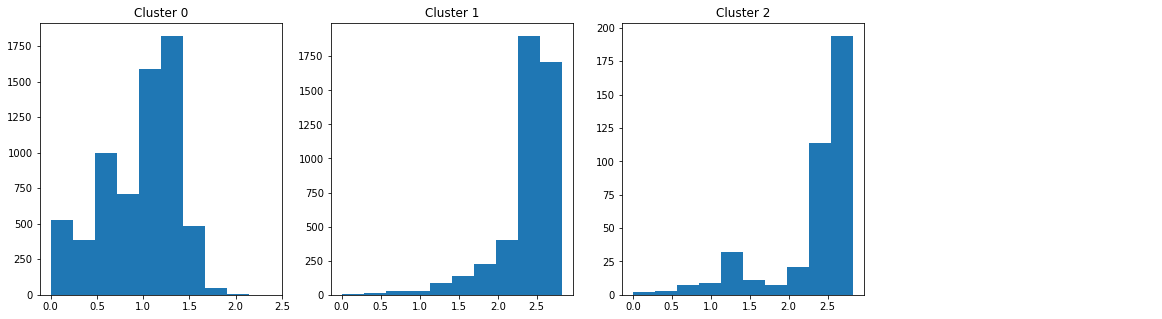

In [ ]:
data_list = []

for i in range(0, n_clusters):
  accounts = users.iloc[labels == i][col]
  data_list.append(accounts)

plot_hist_grid(data_list, n_bins=10, figsize=figsize)

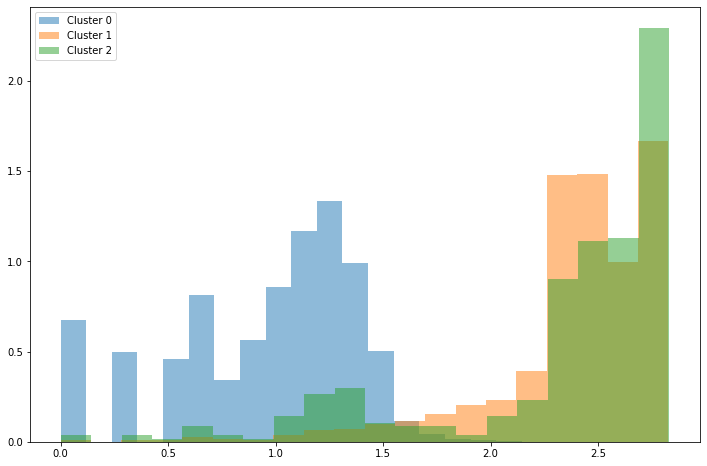

In [ ]:
data_list = []

for i in range(0, n_clusters):
  accounts = users.iloc[labels == i][col]
  data_list.append(accounts)


print_overlapping_histograms(data_list)

# URLS number total distribution per cluster

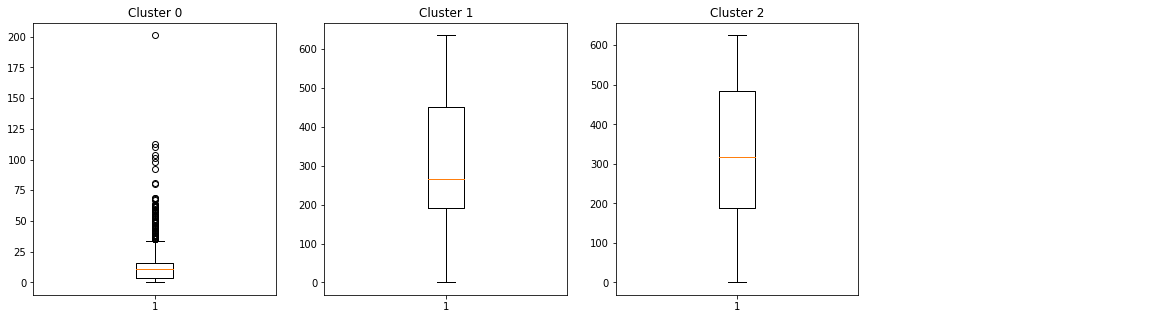

In [ ]:
col = "num_urls_total"
data_list = []

for i in range(0, n_clusters):
  accounts = users.iloc[labels == i][col]
  data_list.append(accounts)

plot_boxplot_grid(data_list, figsize=figsize)

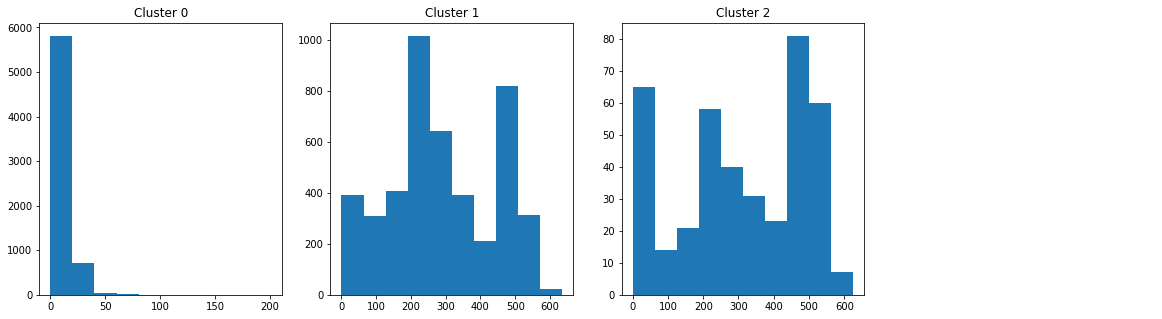

In [ ]:
data_list = []

for i in range(0, n_clusters):
  accounts = users.iloc[labels == i][col]
  data_list.append(accounts)

plot_hist_grid(data_list, n_bins=10, figsize=figsize)

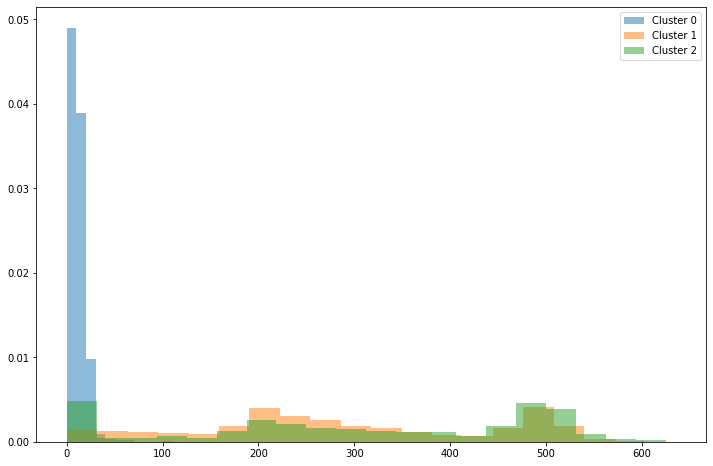

In [ ]:
data_list = []

for i in range(0, n_clusters):
  accounts = users.iloc[labels == i][col]
  data_list.append(accounts)


print_overlapping_histograms(data_list)

# Mentions number total distribution per cluster

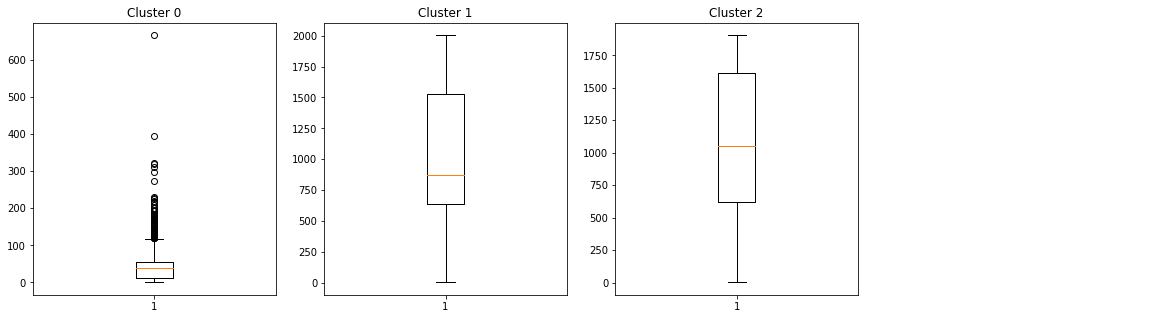

In [ ]:
col = "num_mentions_total"
data_list = []

for i in range(0, n_clusters):
  accounts = users.iloc[labels == i][col]
  data_list.append(accounts)

plot_boxplot_grid(data_list, figsize=figsize)

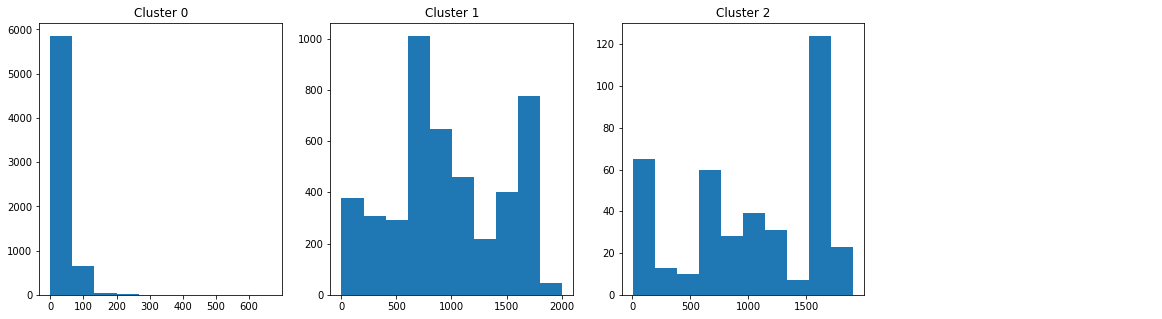

In [ ]:
data_list = []

for i in range(0, n_clusters):
  accounts = users.iloc[labels == i][col]
  data_list.append(accounts)

plot_hist_grid(data_list, n_bins=10, figsize=figsize)

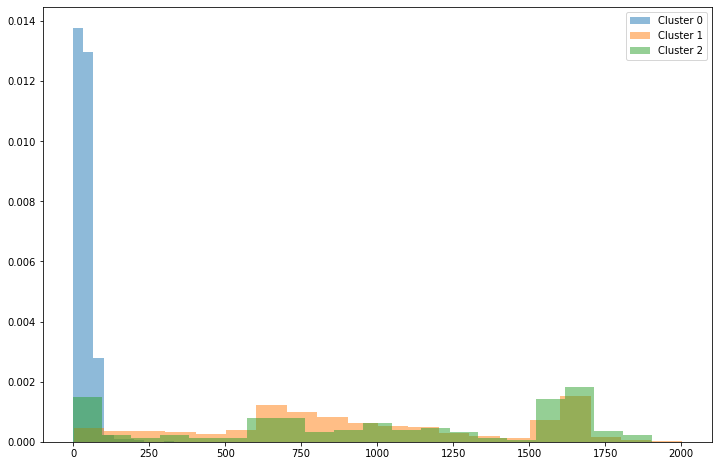

In [ ]:
data_list = []

for i in range(0, n_clusters):
  accounts = users.iloc[labels == i][col]
  data_list.append(accounts)


print_overlapping_histograms(data_list)

# Retweet count average distribution per cluster

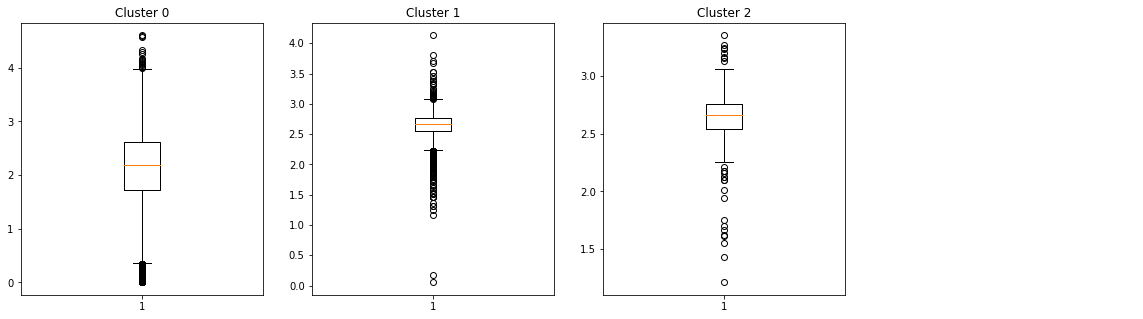

In [ ]:
col = "retweet_count_avg"
data_list = []

for i in range(0, n_clusters):
  accounts = users.iloc[labels == i][col]
  data_list.append(accounts)

plot_boxplot_grid(data_list, figsize=figsize)

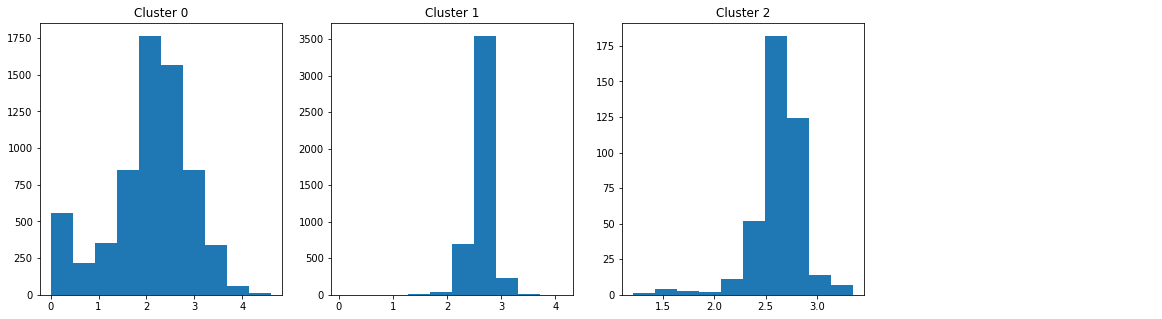

In [ ]:
data_list = []

for i in range(0, n_clusters):
  accounts = users.iloc[labels == i][col]
  data_list.append(accounts)

plot_hist_grid(data_list, n_bins=10, figsize=figsize)

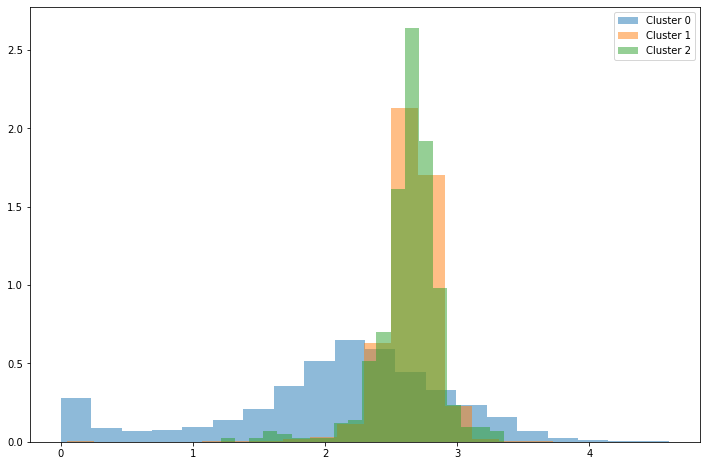

In [ ]:
data_list = []

for i in range(0, n_clusters):
  accounts = users.iloc[labels == i][col]
  data_list.append(accounts)


print_overlapping_histograms(data_list)

# Reply count average distribution per cluster

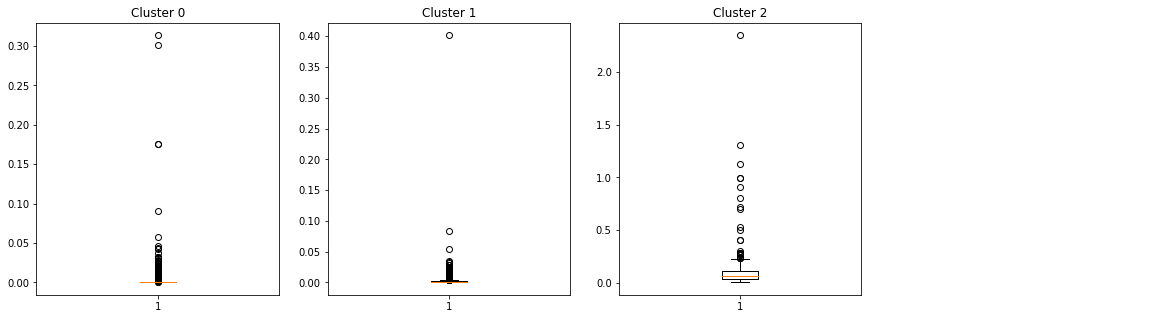

In [ ]:
col = "reply_count_avg"
data_list = []

for i in range(0, n_clusters):
  accounts = users.iloc[labels == i][col]
  data_list.append(accounts)

plot_boxplot_grid(data_list, figsize=figsize)

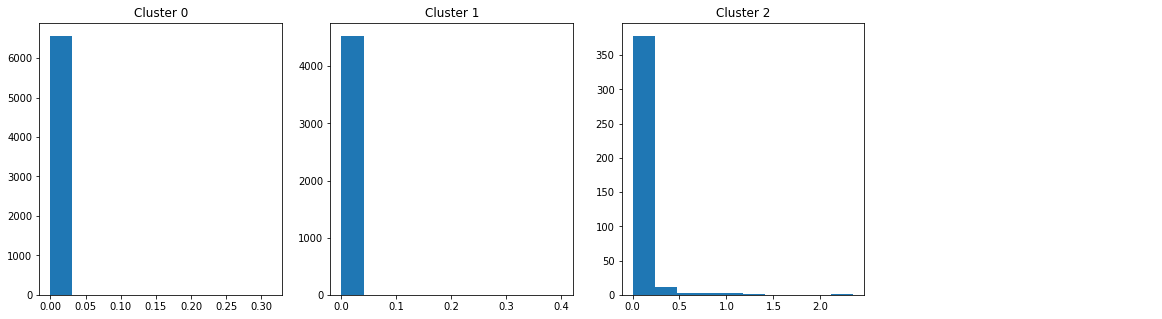

In [ ]:
data_list = []

for i in range(0, n_clusters):
  accounts = users.iloc[labels == i][col]
  data_list.append(accounts)

plot_hist_grid(data_list, n_bins=10, figsize=figsize)

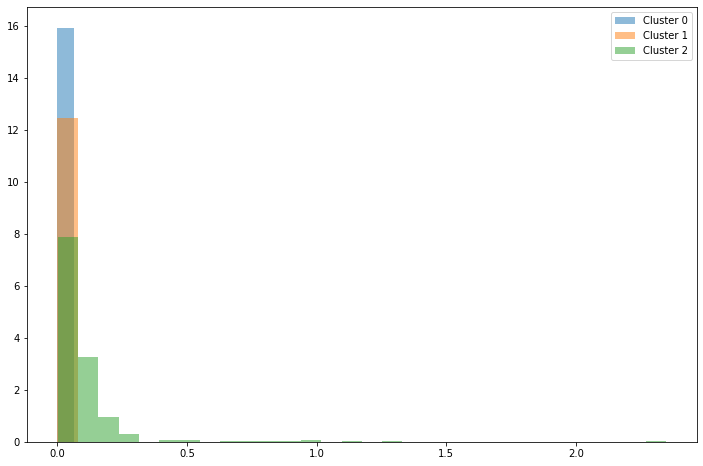

In [ ]:
data_list = []

for i in range(0, n_clusters):
  accounts = users.iloc[labels == i][col]
  data_list.append(accounts)


print_overlapping_histograms(data_list, [5, 5, 30])

# Favorite count average distribution per cluster

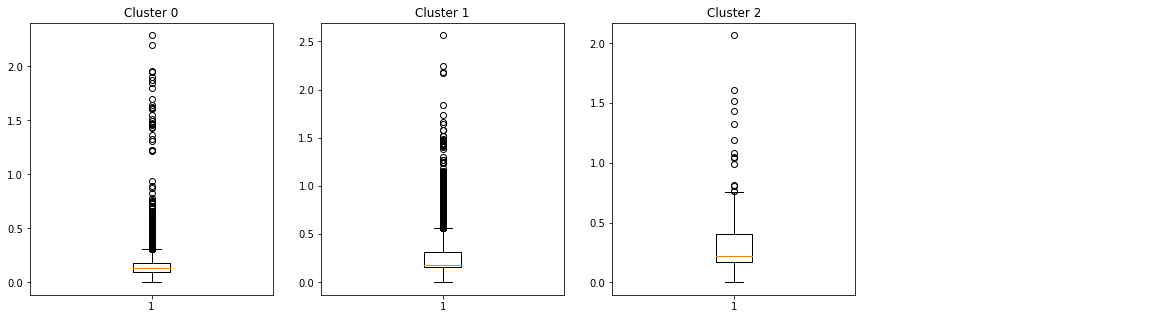

In [ ]:
col = "favorite_count_avg"
data_list = []

for i in range(0, n_clusters):
  accounts = users.iloc[labels == i][col]
  data_list.append(accounts)

plot_boxplot_grid(data_list, figsize=figsize)

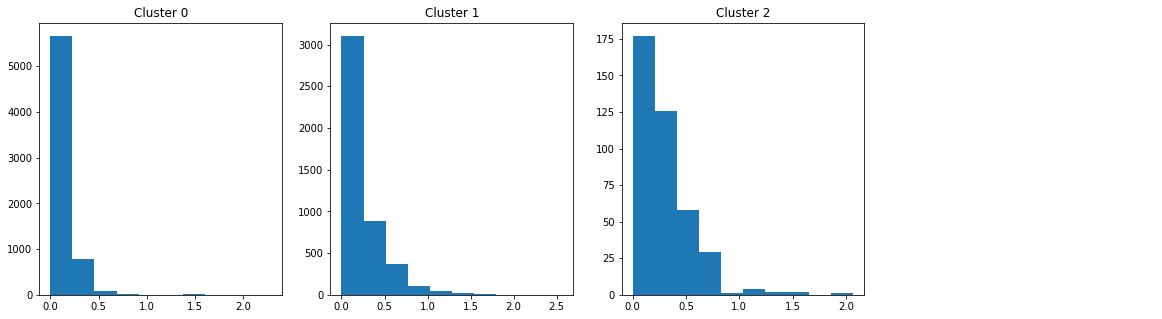

In [ ]:
data_list = []

for i in range(0, n_clusters):
  accounts = users.iloc[labels == i][col]
  data_list.append(accounts)

plot_hist_grid(data_list, n_bins=10, figsize=figsize)

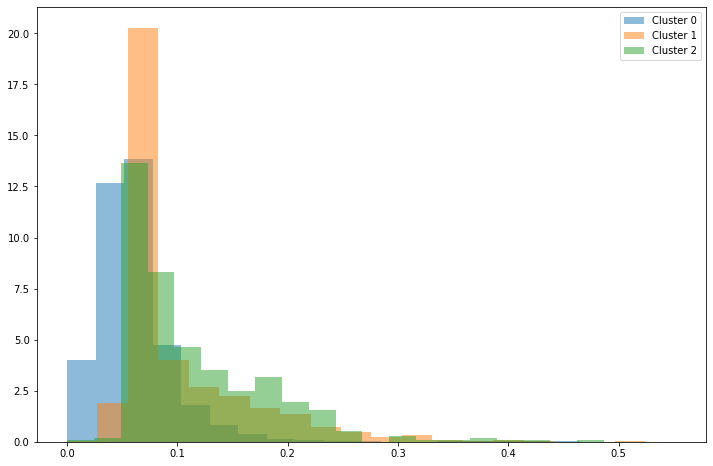

In [ ]:
data_list = []

for i in range(0, n_clusters):
  accounts = users.iloc[labels == i][col].apply(lambda x: np.log10(x+1))
  data_list.append(accounts)


print_overlapping_histograms(data_list)

# Hashtags number average distribution per cluster

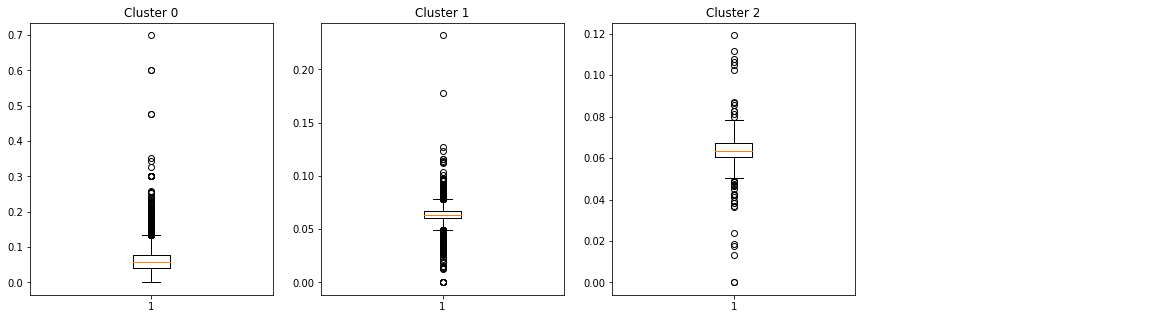

In [ ]:
col = "num_hashtags_avg"
data_list = []

for i in range(0, n_clusters):
  accounts = users.iloc[labels == i][col]
  data_list.append(accounts)

plot_boxplot_grid(data_list, figsize=figsize)

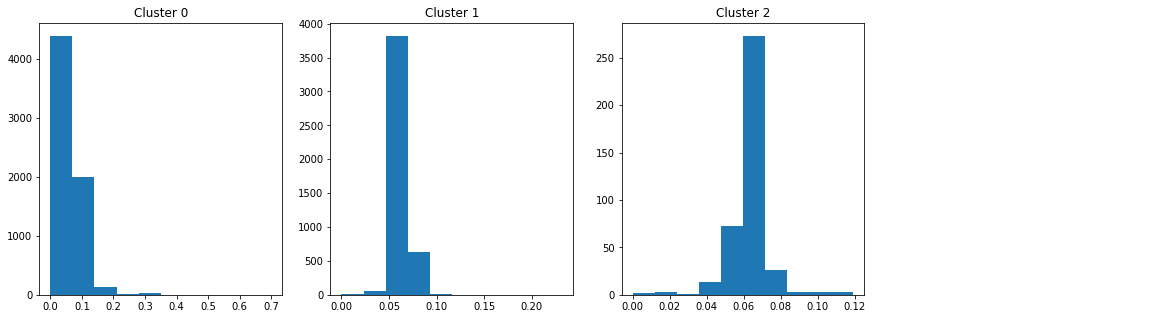

In [ ]:
data_list = []

for i in range(0, n_clusters):
  accounts = users.iloc[labels == i][col]
  data_list.append(accounts)

plot_hist_grid(data_list, n_bins=10, figsize=figsize)

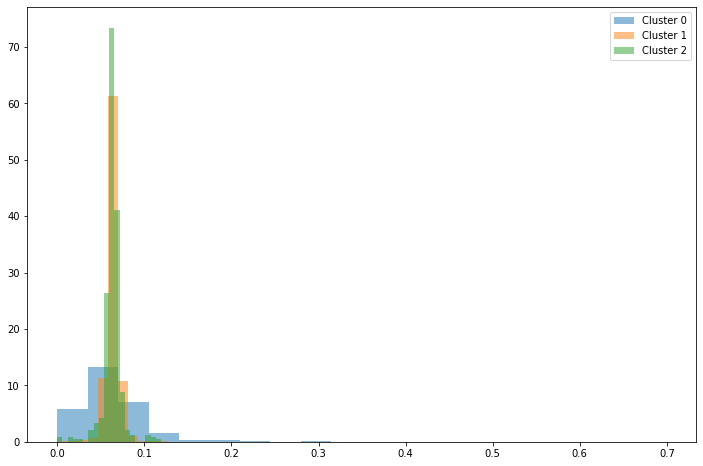

In [ ]:
data_list = []

for i in range(0, n_clusters):
  accounts = users.iloc[labels == i][col]
  data_list.append(accounts)


print_overlapping_histograms(data_list)

# URLS number average distribution per cluster

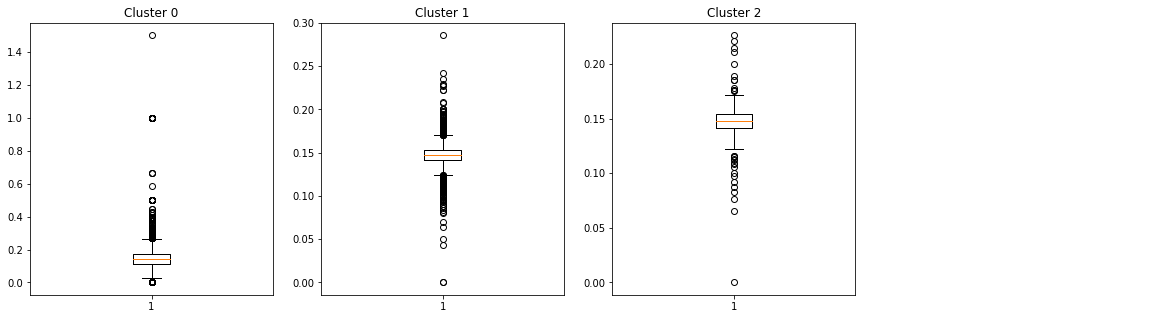

In [ ]:
col = "num_urls_avg"
data_list = []

for i in range(0, n_clusters):
  accounts = users.iloc[labels == i][col]
  data_list.append(accounts)

plot_boxplot_grid(data_list, figsize=figsize)

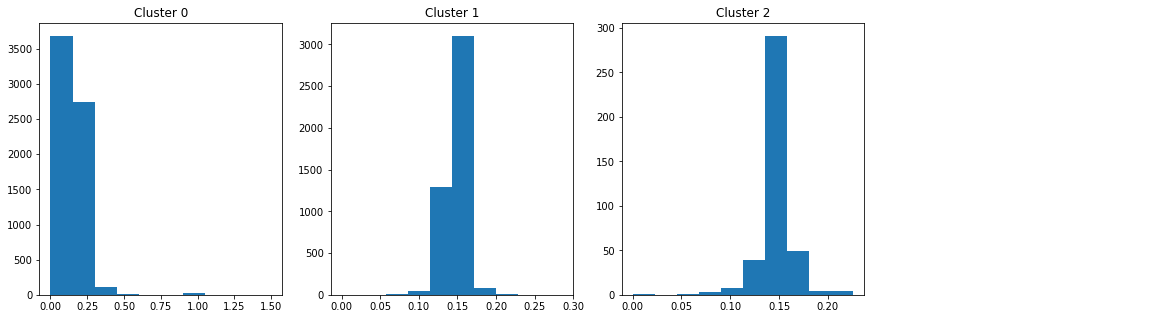

In [ ]:
data_list = []

for i in range(0, n_clusters):
  accounts = users.iloc[labels == i][col]
  data_list.append(accounts)

plot_hist_grid(data_list, n_bins=10, figsize=figsize)

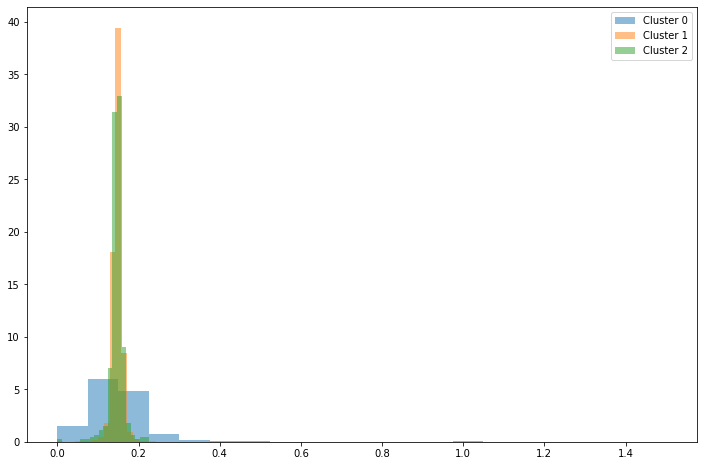

In [ ]:
data_list = []

for i in range(0, n_clusters):
  accounts = users.iloc[labels == i][col]
  data_list.append(accounts)


print_overlapping_histograms(data_list)

# Mentions number average distribution per cluster

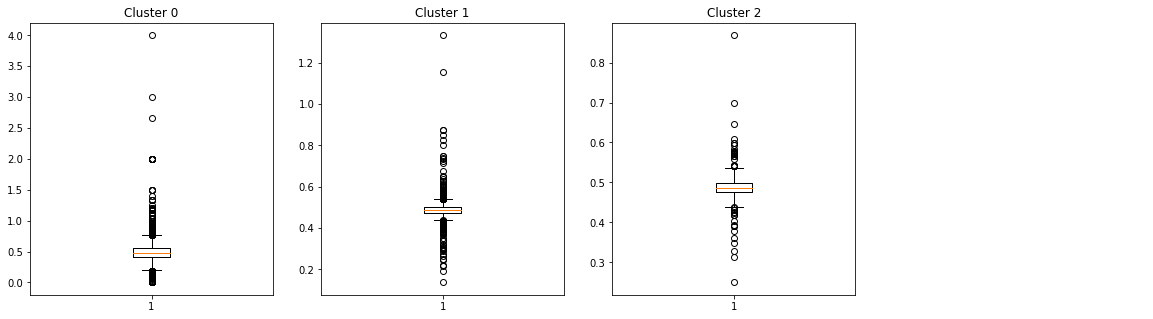

In [ ]:
col = "num_mentions_avg"
data_list = []

for i in range(0, n_clusters):
  accounts = users.iloc[labels == i][col]
  data_list.append(accounts)

plot_boxplot_grid(data_list, figsize=figsize)

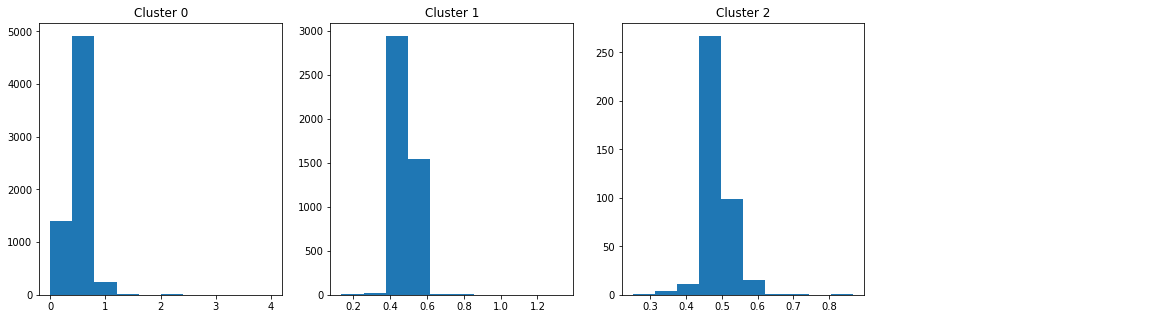

In [ ]:
data_list = []

for i in range(0, n_clusters):
  accounts = users.iloc[labels == i][col]
  data_list.append(accounts)

plot_hist_grid(data_list, n_bins=10, figsize=figsize)

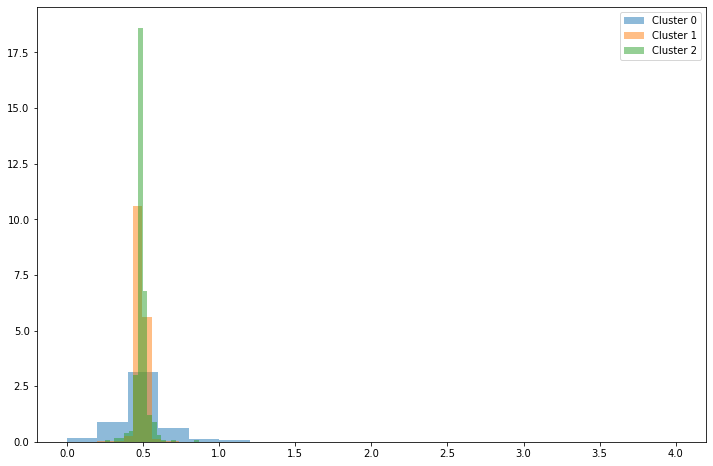

In [ ]:
data_list = []

for i in range(0, n_clusters):
  accounts = users.iloc[labels == i][col]
  data_list.append(accounts)


print_overlapping_histograms(data_list)

# Retweet count standard deviation distribution per cluster

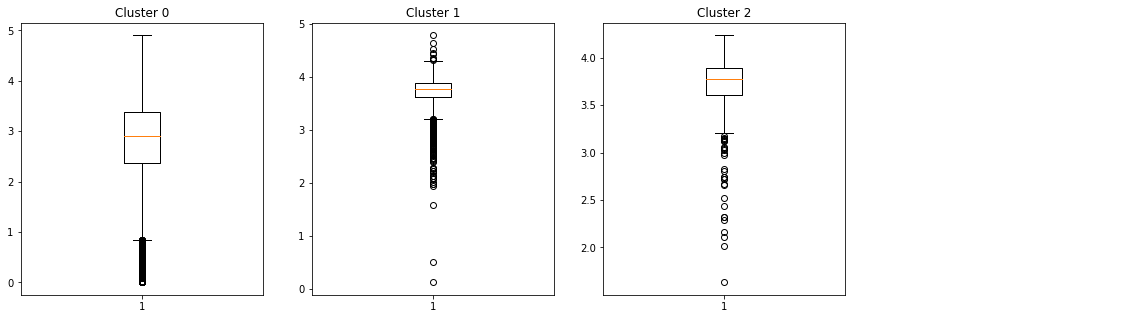

In [ ]:
col = "retweet_count_std"
data_list = []

for i in range(0, n_clusters):
  accounts = users.iloc[labels == i][col]
  data_list.append(accounts)

plot_boxplot_grid(data_list, figsize=figsize)

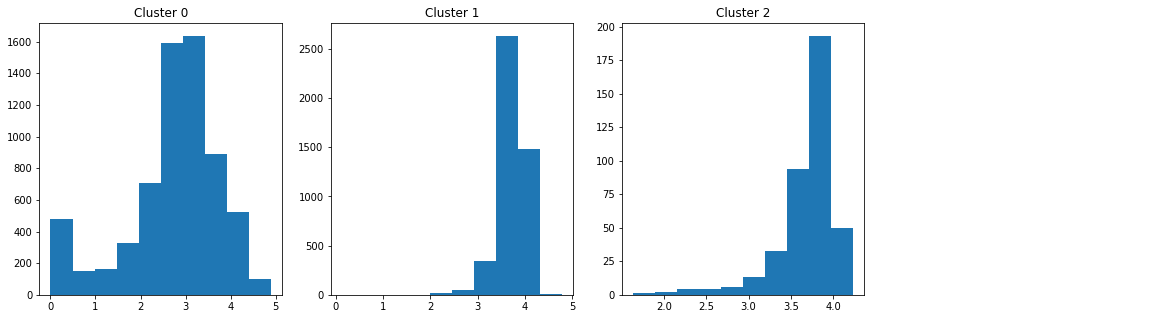

In [ ]:
data_list = []

for i in range(0, n_clusters):
  accounts = users.iloc[labels == i][col]
  data_list.append(accounts)

plot_hist_grid(data_list, n_bins=10, figsize=figsize)

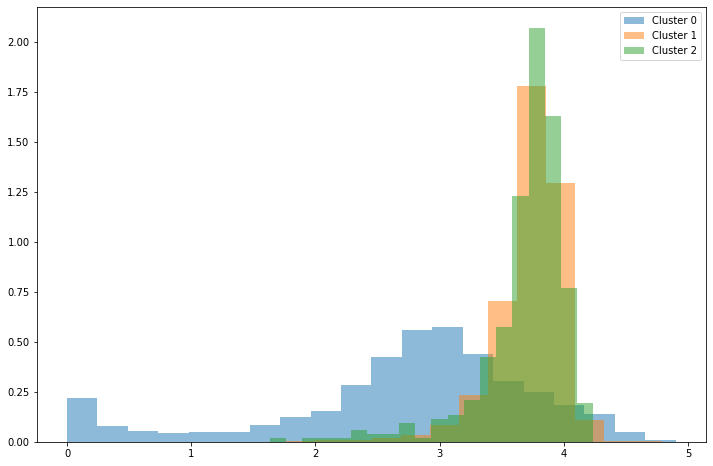

In [ ]:
data_list = []

for i in range(0, n_clusters):
  accounts = users.iloc[labels == i][col]
  data_list.append(accounts)


print_overlapping_histograms(data_list)

# Reply count standard deviation distribution per cluster

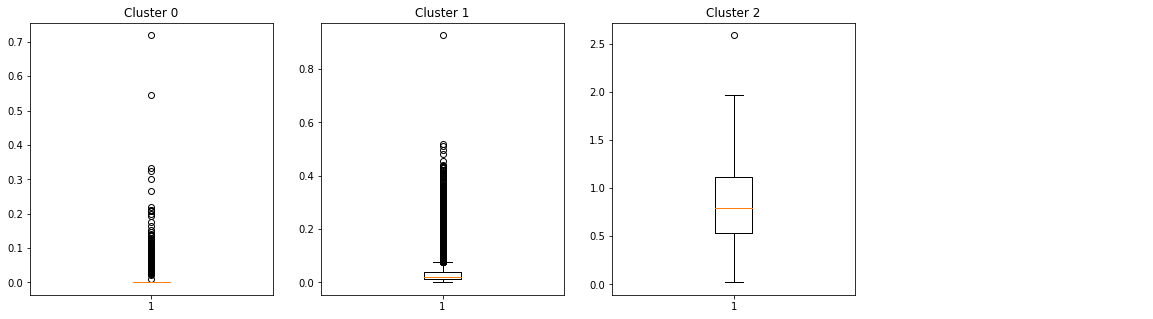

In [ ]:
col = "reply_count_std"
data_list = []

for i in range(0, n_clusters):
  accounts = users.iloc[labels == i][col]
  data_list.append(accounts)

plot_boxplot_grid(data_list, figsize=figsize)

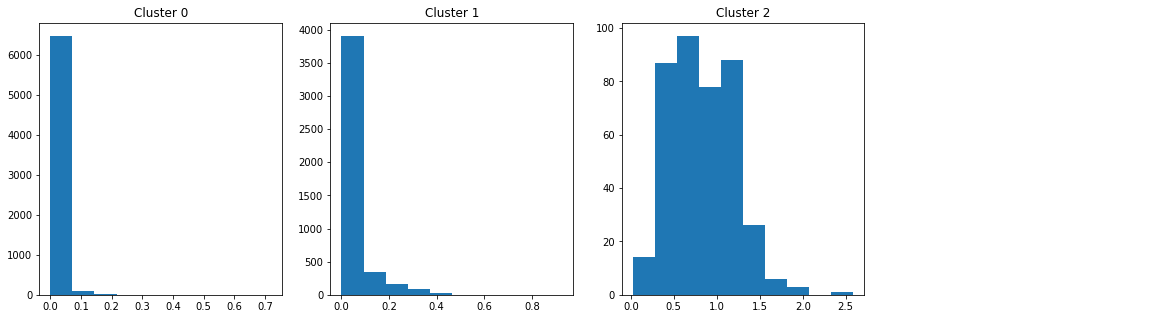

In [ ]:
data_list = []

for i in range(0, n_clusters):
  accounts = users.iloc[labels == i][col]
  data_list.append(accounts)

plot_hist_grid(data_list, n_bins=10, figsize=figsize)

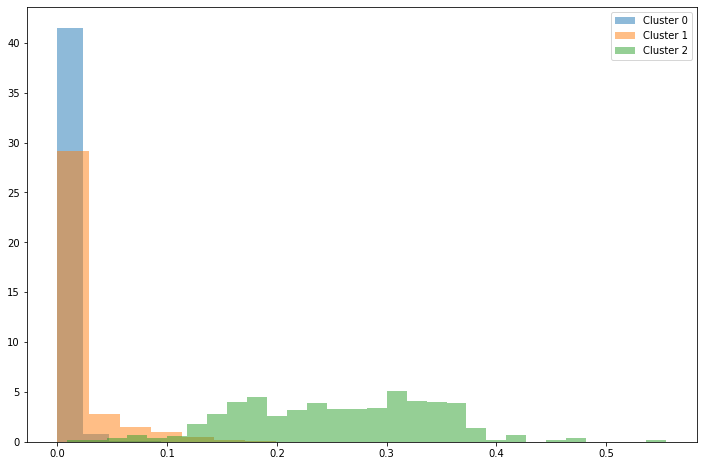

In [ ]:
data_list = []

for i in range(0, n_clusters):
  accounts = users.iloc[labels == i][col].apply(lambda x: np.log10(x+1))
  data_list.append(accounts)


print_overlapping_histograms(data_list, [10, 10, 30])

# Favorite count standard deviation distribution per cluster

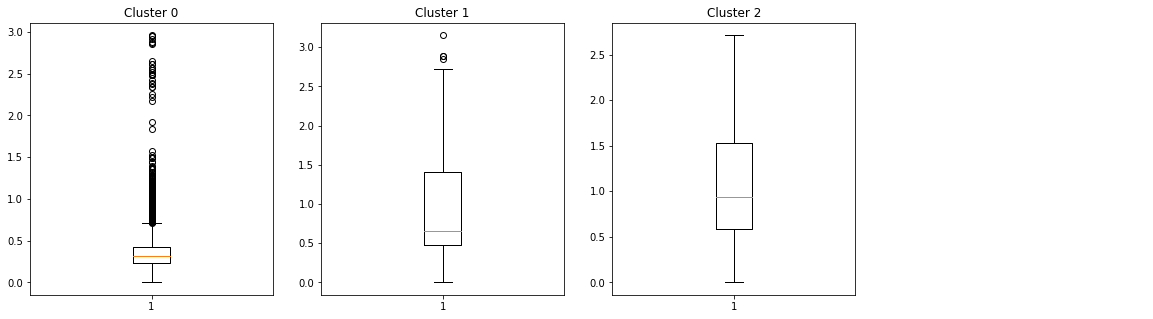

In [ ]:
col = "favorite_count_std"
data_list = []

for i in range(0, n_clusters):
  accounts = users.iloc[labels == i][col]
  data_list.append(accounts)

plot_boxplot_grid(data_list, figsize=figsize)

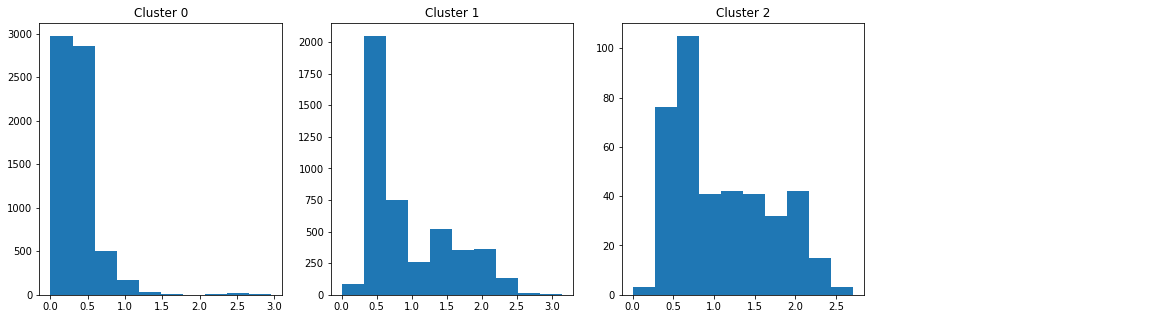

In [ ]:
data_list = []

for i in range(0, n_clusters):
  accounts = users.iloc[labels == i][col]
  data_list.append(accounts)

plot_hist_grid(data_list, n_bins=10, figsize=figsize)

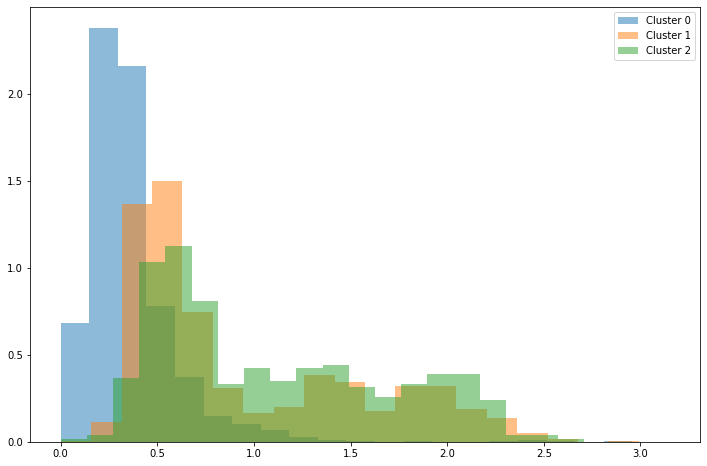

In [ ]:
data_list = []

for i in range(0, n_clusters):
  accounts = users.iloc[labels == i][col]
  data_list.append(accounts)


print_overlapping_histograms(data_list)

# Hashtags number standard deviation distribution per cluster

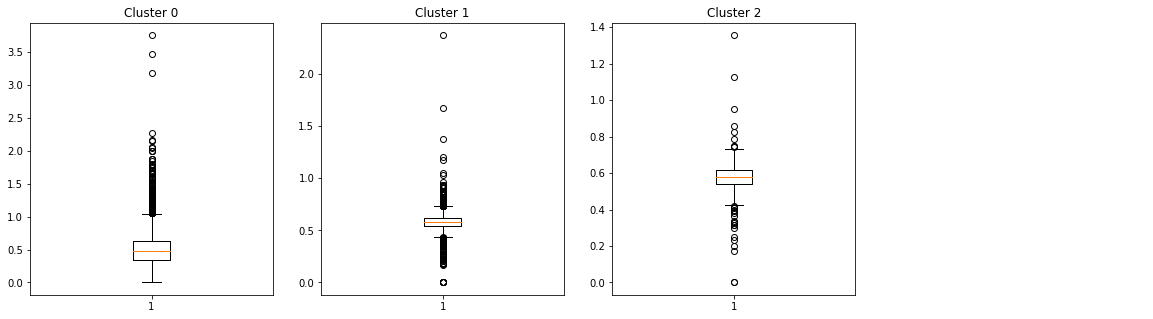

In [ ]:
col = "num_hashtags_std"
data_list = []

for i in range(0, n_clusters):
  accounts = users.iloc[labels == i][col]
  data_list.append(accounts)

plot_boxplot_grid(data_list, figsize=figsize)

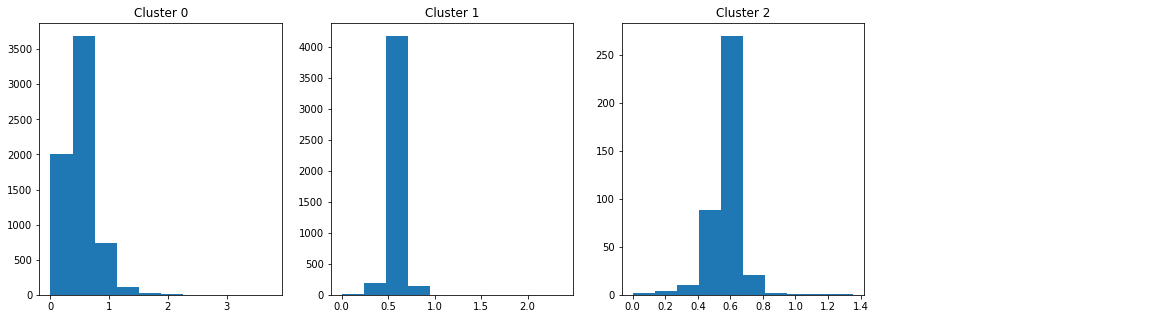

In [ ]:
data_list = []

for i in range(0, n_clusters):
  accounts = users.iloc[labels == i][col]
  data_list.append(accounts)

plot_hist_grid(data_list, n_bins=10, figsize=figsize)

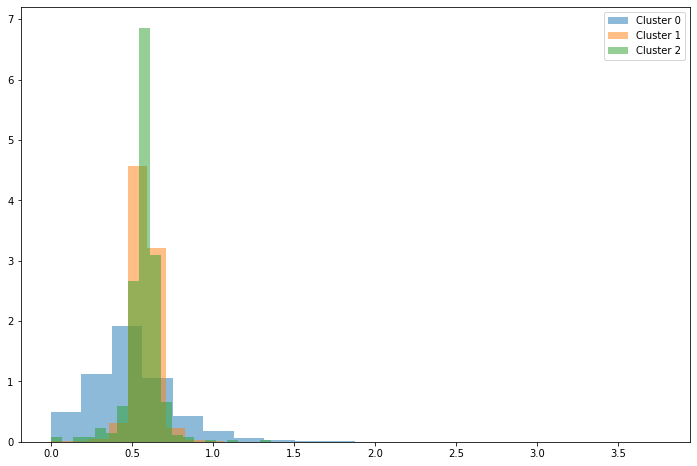

In [ ]:
data_list = []

for i in range(0, n_clusters):
  accounts = users.iloc[labels == i][col]
  data_list.append(accounts)


print_overlapping_histograms(data_list)

# URLS number standard deviation distribution per cluster

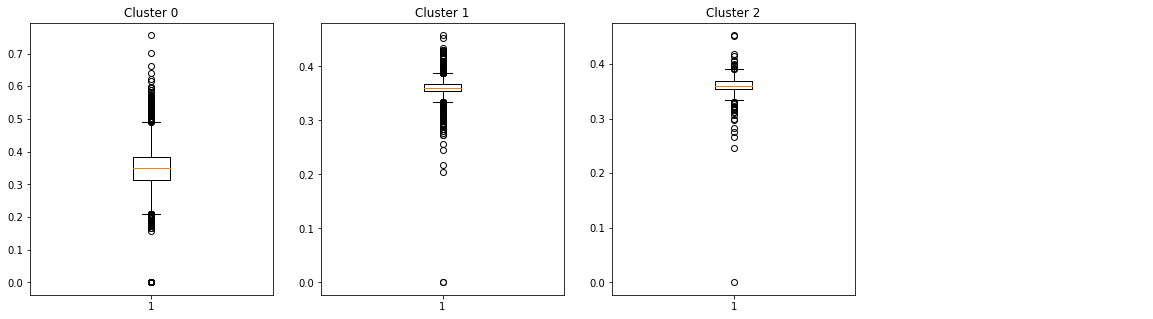

In [ ]:
col = "num_urls_std"
data_list = []

for i in range(0, n_clusters):
  accounts = users.iloc[labels == i][col]
  data_list.append(accounts)

plot_boxplot_grid(data_list, figsize=figsize)

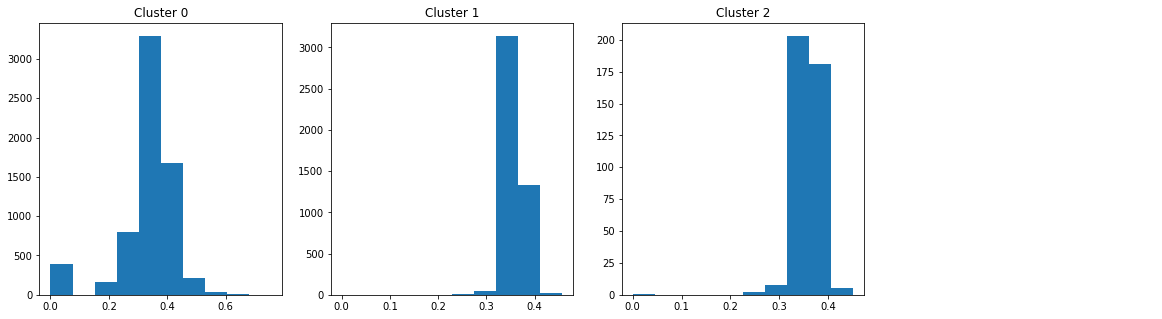

In [ ]:
data_list = []

for i in range(0, n_clusters):
  accounts = users.iloc[labels == i][col]
  data_list.append(accounts)

plot_hist_grid(data_list, n_bins=10, figsize=figsize)

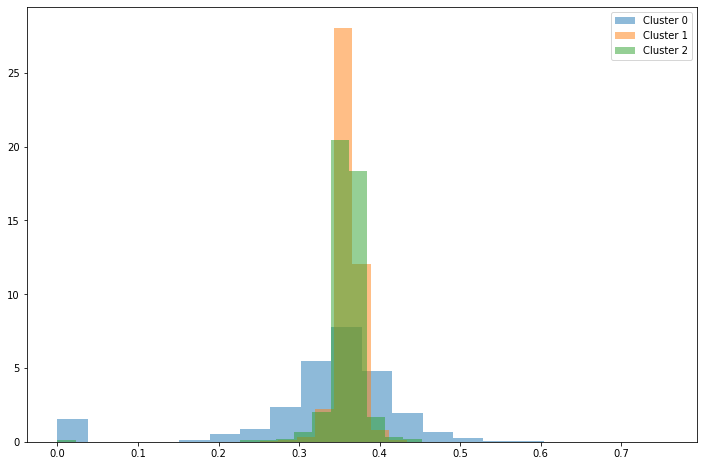

In [ ]:
data_list = []

for i in range(0, n_clusters):
  accounts = users.iloc[labels == i][col]
  data_list.append(accounts)


print_overlapping_histograms(data_list)

# Mentions number standard deviation distribution per cluster

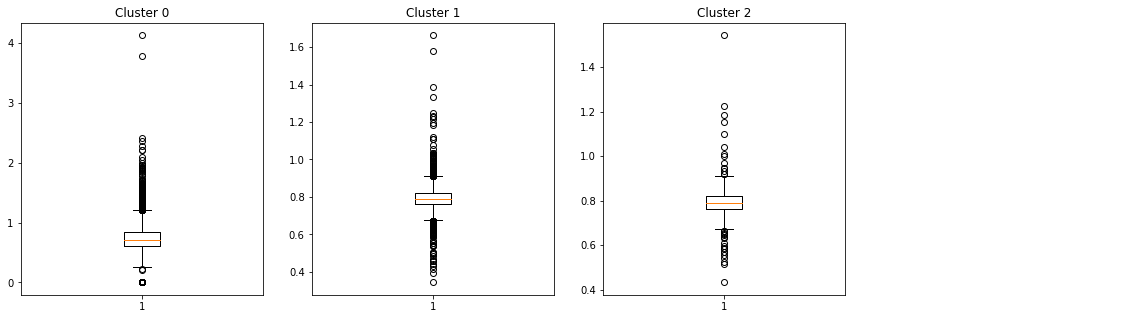

In [ ]:
col = "num_mentions_std"
data_list = []

for i in range(0, n_clusters):
  accounts = users.iloc[labels == i][col]
  data_list.append(accounts)

plot_boxplot_grid(data_list, figsize=figsize)

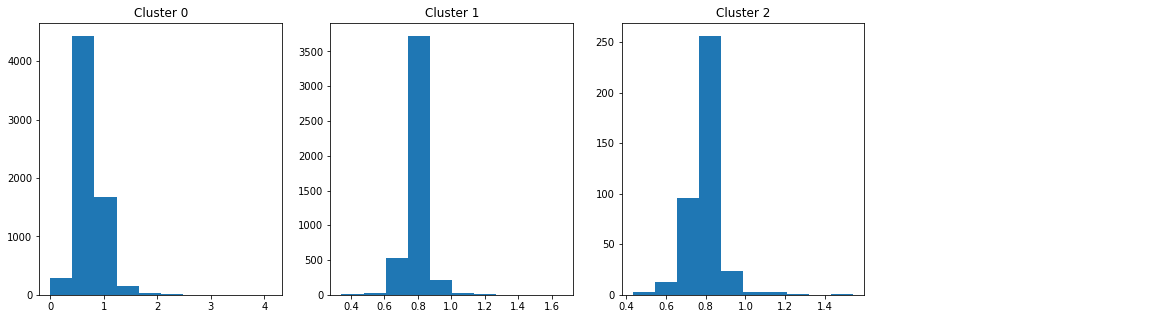

In [ ]:
data_list = []

for i in range(0, n_clusters):
  accounts = users.iloc[labels == i][col]
  data_list.append(accounts)

plot_hist_grid(data_list, n_bins=10, figsize=figsize)

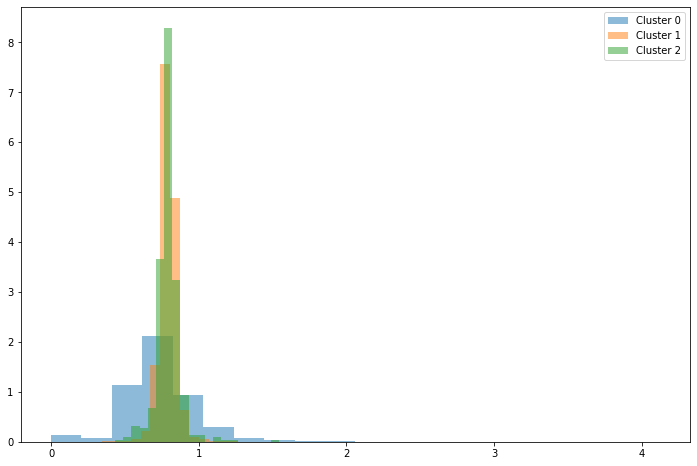

In [ ]:
data_list = []

for i in range(0, n_clusters):
  accounts = users.iloc[labels == i][col]
  data_list.append(accounts)


print_overlapping_histograms(data_list)

# Retweet count per day distribution per cluster

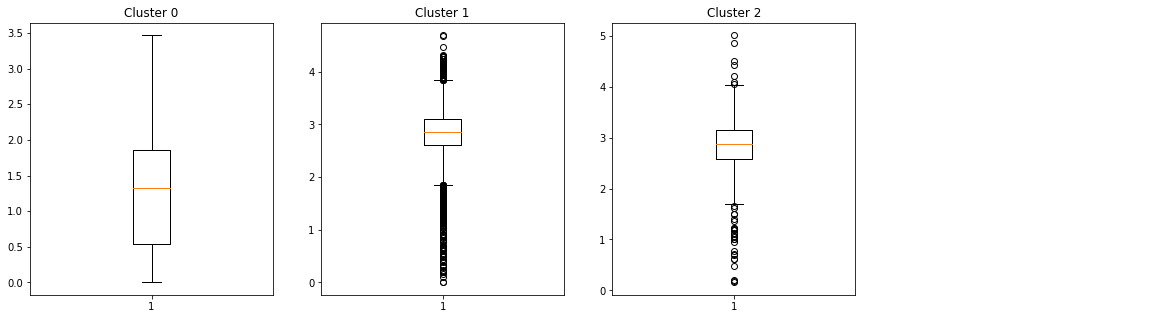

In [ ]:
col = "retweet_count_per_day"
data_list = []

for i in range(0, n_clusters):
  accounts = users.iloc[labels == i][col]
  data_list.append(accounts)

plot_boxplot_grid(data_list, figsize=figsize)

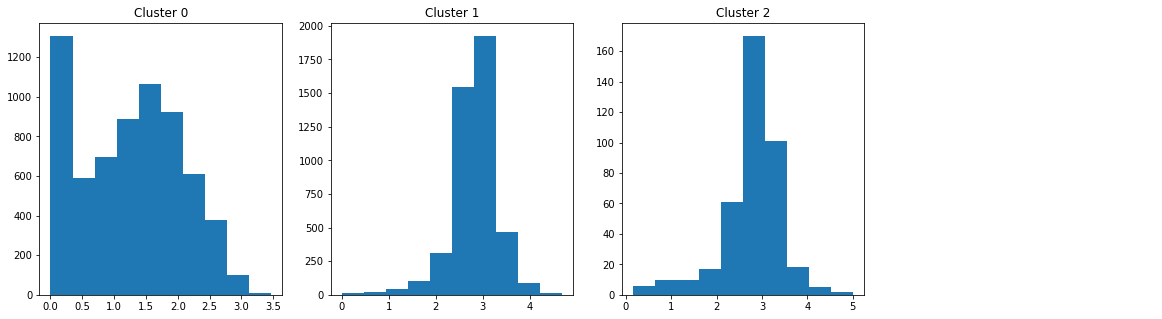

In [ ]:
data_list = []

for i in range(0, n_clusters):
  accounts = users.iloc[labels == i][col]
  data_list.append(accounts)

plot_hist_grid(data_list, n_bins=10, figsize=figsize)

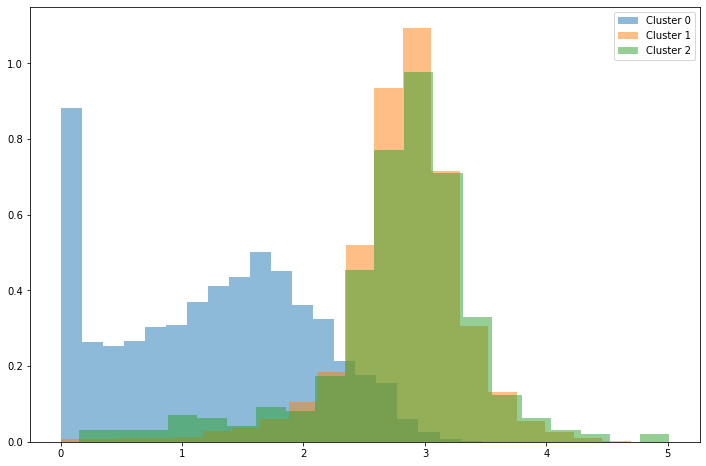

In [ ]:
data_list = []

for i in range(0, n_clusters):
  accounts = users.iloc[labels == i][col]
  data_list.append(accounts)


print_overlapping_histograms(data_list)

# Reply count per day distribution per cluster

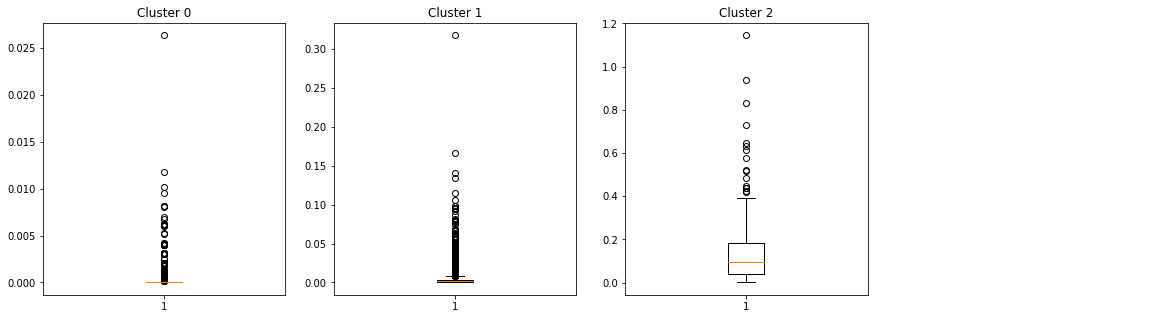

In [ ]:
col = "reply_count_per_day"
data_list = []

for i in range(0, n_clusters):
  accounts = users.iloc[labels == i][col]
  data_list.append(accounts)

plot_boxplot_grid(data_list, figsize=figsize)

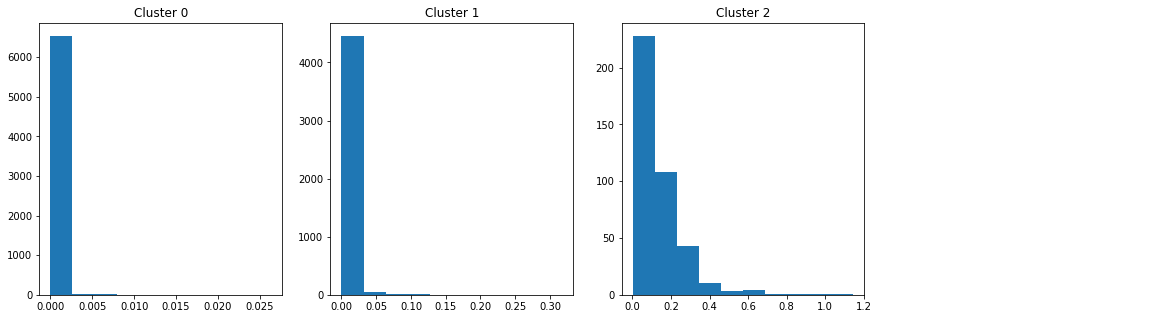

In [ ]:
data_list = []

for i in range(0, n_clusters):
  accounts = users.iloc[labels == i][col]
  data_list.append(accounts)

plot_hist_grid(data_list, n_bins=10, figsize=figsize)

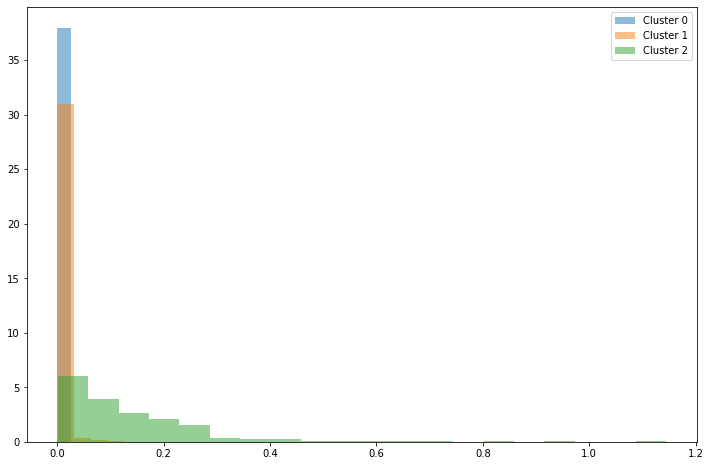

In [ ]:
data_list = []

for i in range(0, n_clusters):
  accounts = users.iloc[labels == i][col]
  data_list.append(accounts)


print_overlapping_histograms(data_list, [1, 10, 20])

# Favorite count per day distribution per cluster

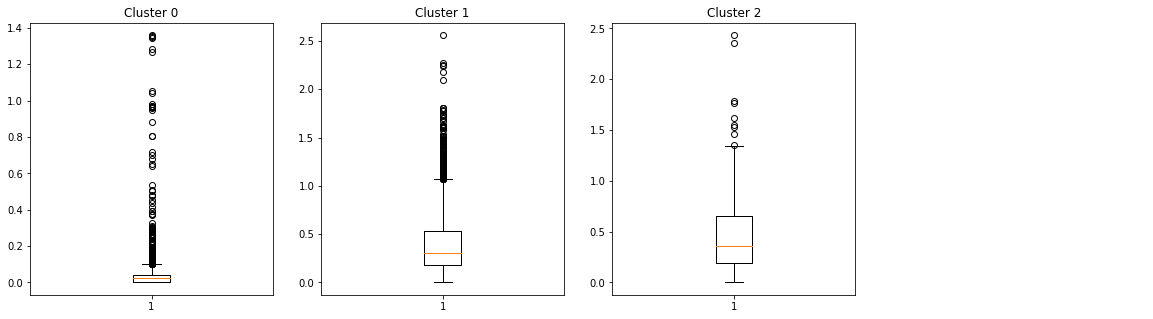

In [ ]:
col = "favorite_count_per_day"
data_list = []

for i in range(0, n_clusters):
  accounts = users.iloc[labels == i][col]
  data_list.append(accounts)

plot_boxplot_grid(data_list, figsize=figsize)

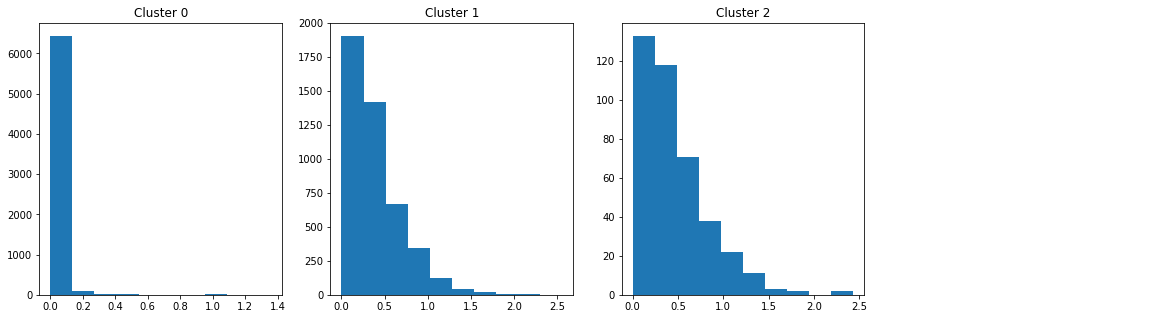

In [ ]:
data_list = []

for i in range(0, n_clusters):
  accounts = users.iloc[labels == i][col]
  data_list.append(accounts)

plot_hist_grid(data_list, n_bins=10, figsize=figsize)

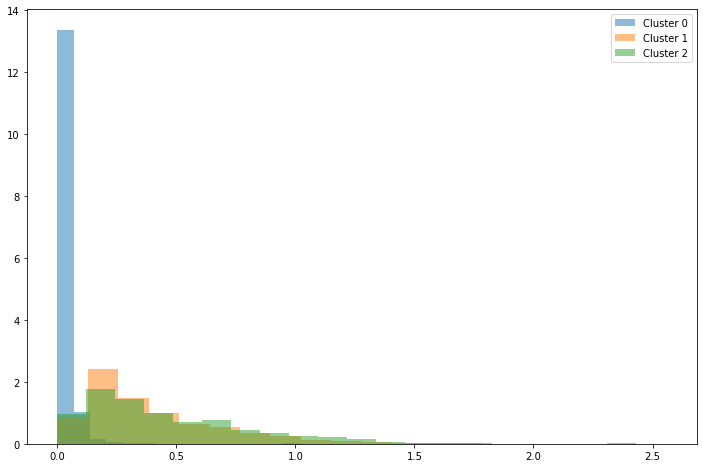

In [ ]:
data_list = []

for i in range(0, n_clusters):
  accounts = users.iloc[labels == i][col]
  data_list.append(accounts)


print_overlapping_histograms(data_list)

# Hashtags number per day distribution per cluster

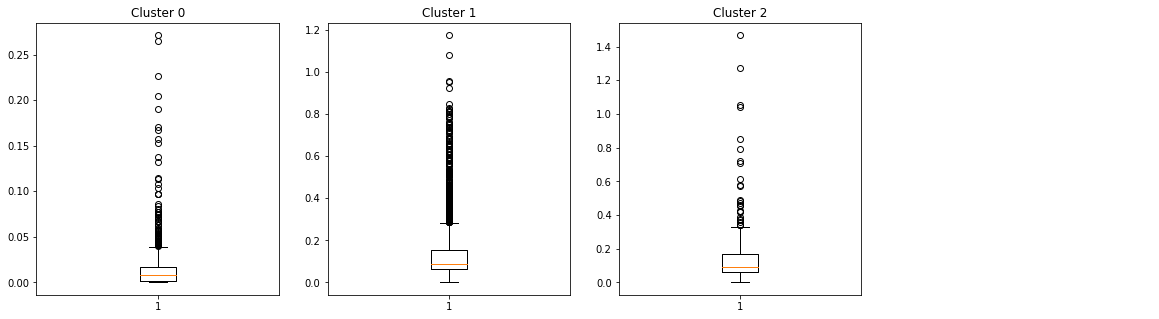

In [ ]:
col = "num_hashtags_per_day"
data_list = []

for i in range(0, n_clusters):
  accounts = users.iloc[labels == i][col]
  data_list.append(accounts)

plot_boxplot_grid(data_list, figsize=figsize)

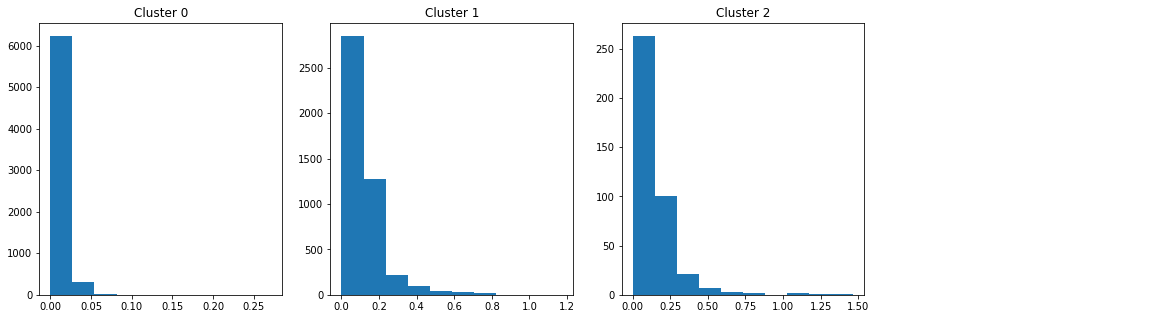

In [ ]:
data_list = []

for i in range(0, n_clusters):
  accounts = users.iloc[labels == i][col]
  data_list.append(accounts)

plot_hist_grid(data_list, n_bins=10, figsize=figsize)

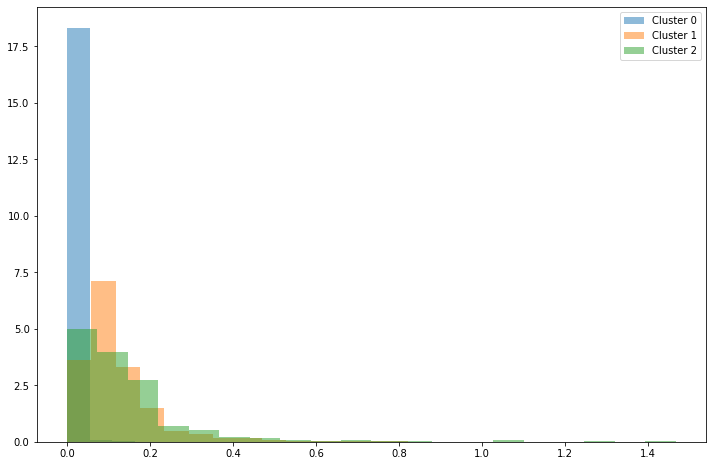

In [ ]:
data_list = []

for i in range(0, n_clusters):
  accounts = users.iloc[labels == i][col]
  data_list.append(accounts)


print_overlapping_histograms(data_list, [5, 20, 20])

# URLS number per_day distribution per cluster

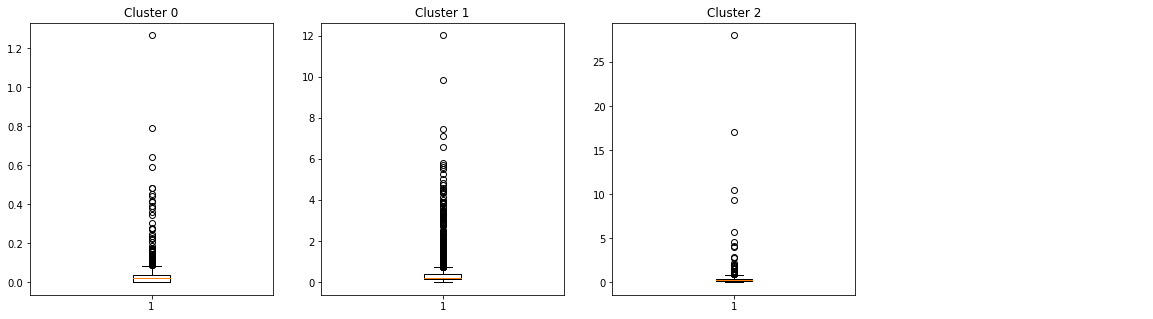

In [ ]:
col = "num_urls_per_day"
data_list = []

for i in range(0, n_clusters):
  accounts = users.iloc[labels == i][col]
  data_list.append(accounts)

plot_boxplot_grid(data_list, figsize=figsize)

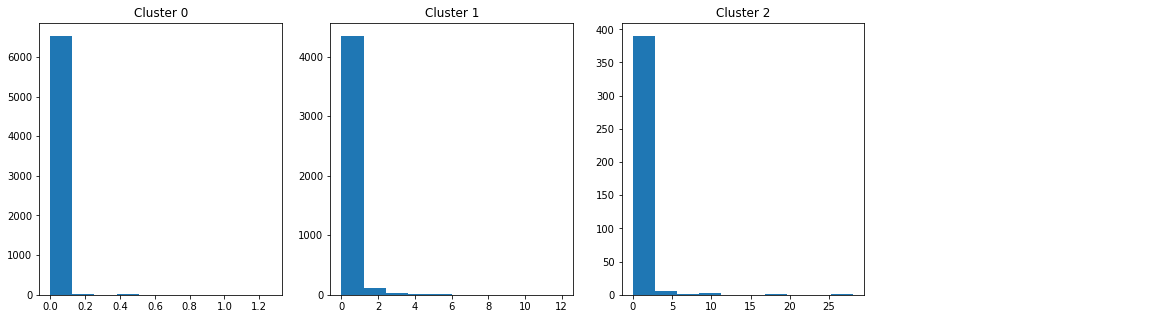

In [ ]:
data_list = []

for i in range(0, n_clusters):
  accounts = users.iloc[labels == i][col]
  data_list.append(accounts)

plot_hist_grid(data_list, n_bins=10, figsize=figsize)

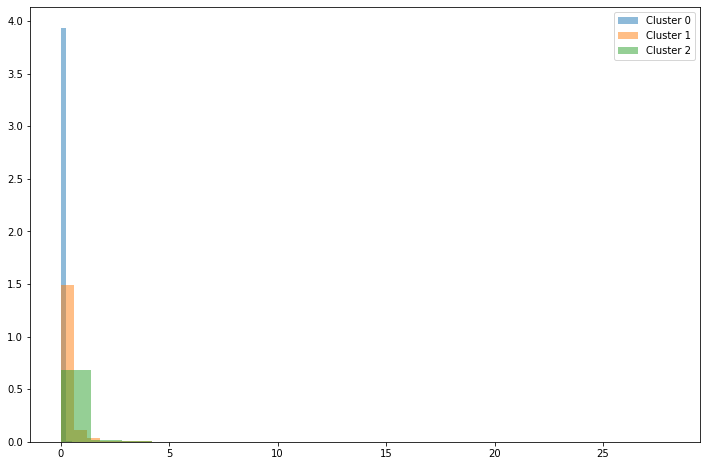

In [ ]:
data_list = []

for i in range(0, n_clusters):
  accounts = users.iloc[labels == i][col]
  data_list.append(accounts)


print_overlapping_histograms(data_list, [5,20,20])

# Mentions number per day distribution per cluster

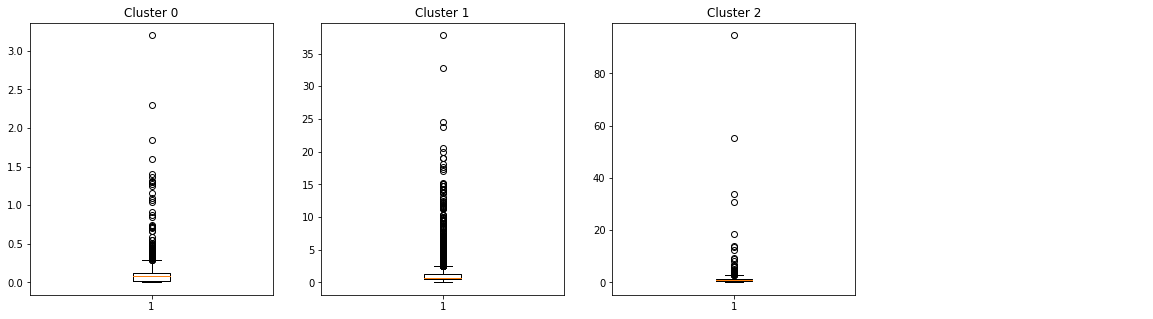

In [ ]:
col = "num_mentions_per_day"
data_list = []

for i in range(0, n_clusters):
  accounts = users.iloc[labels == i][col]
  data_list.append(accounts)

plot_boxplot_grid(data_list, figsize=figsize)

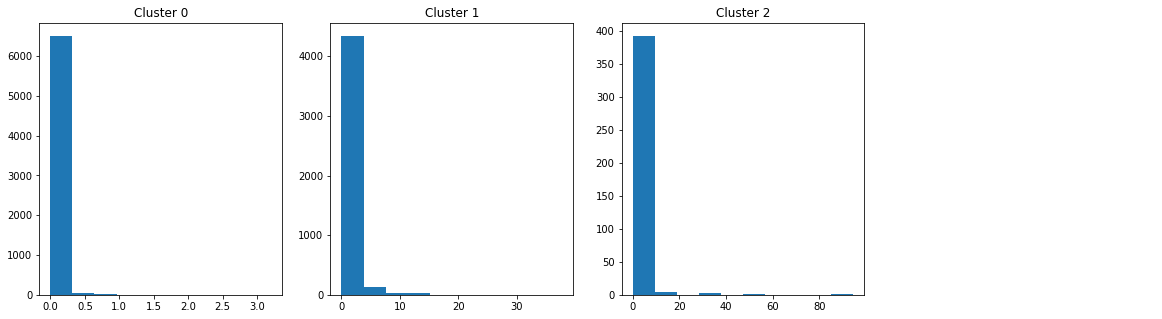

In [ ]:
data_list = []

for i in range(0, n_clusters):
  accounts = users.iloc[labels == i][col]
  data_list.append(accounts)

plot_hist_grid(data_list, n_bins=10, figsize=figsize)

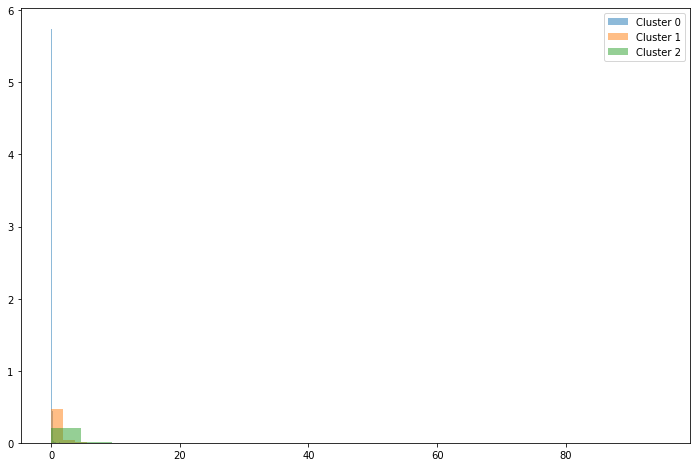

In [ ]:
data_list = []

for i in range(0, n_clusters):
  accounts = users.iloc[labels == i][col]
  data_list.append(accounts)


print_overlapping_histograms(data_list)

# Retweet count entropy distribution per cluster

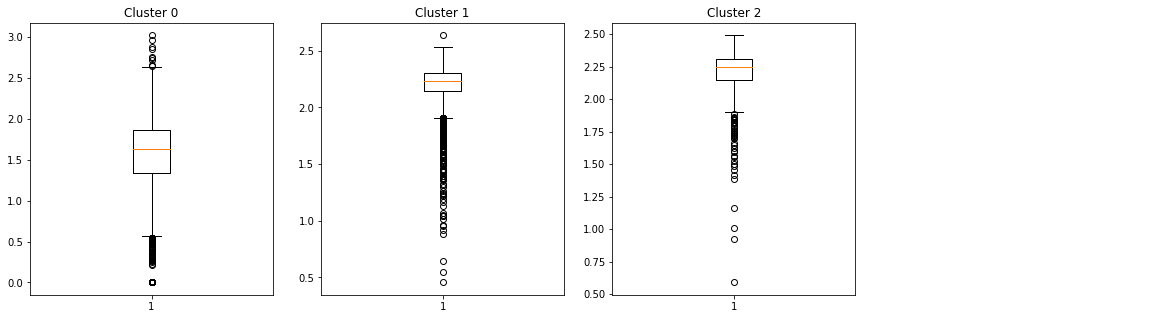

In [ ]:
col = "retweet_count_entropy"
data_list = []

for i in range(0, n_clusters):
  accounts = users.iloc[labels == i][col]
  data_list.append(accounts)

plot_boxplot_grid(data_list, figsize=figsize)

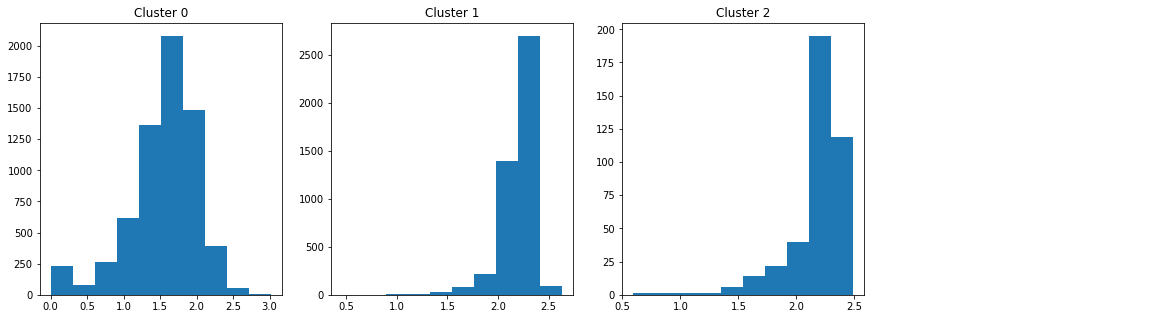

In [ ]:
data_list = []

for i in range(0, n_clusters):
  accounts = users.iloc[labels == i][col]
  data_list.append(accounts)

plot_hist_grid(data_list, n_bins=10, figsize=figsize)

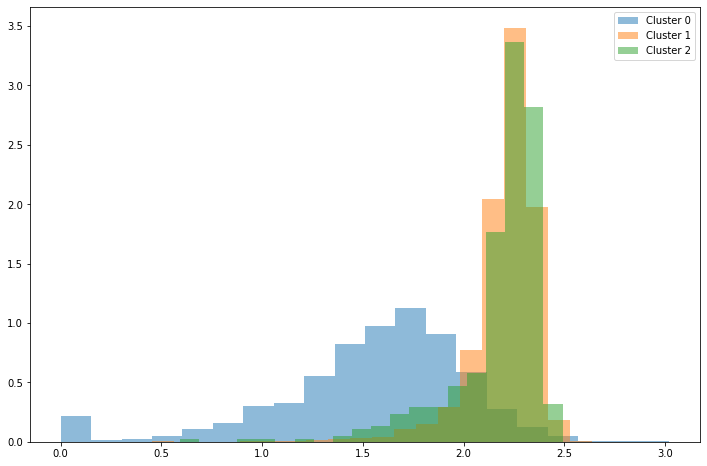

In [ ]:
data_list = []

for i in range(0, n_clusters):
  accounts = users.iloc[labels == i][col]
  data_list.append(accounts)


print_overlapping_histograms(data_list)

# Reply count entropy distribution per cluster

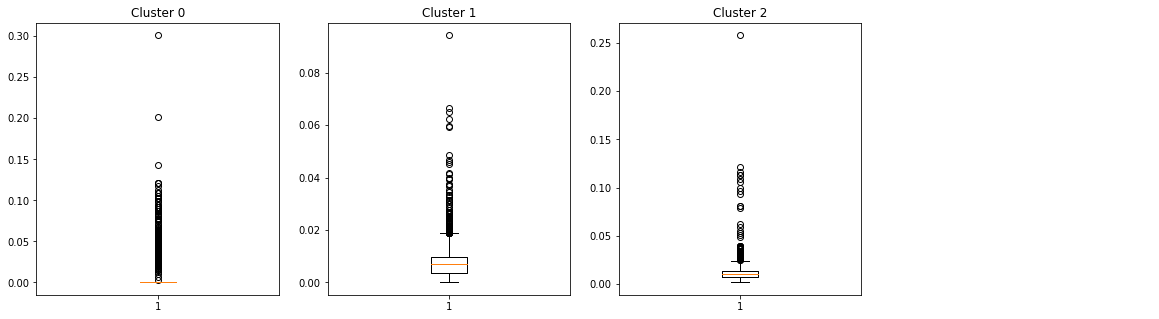

In [ ]:
col = "reply_count_entropy"
data_list = []

for i in range(0, n_clusters):
  accounts = users.iloc[labels == i][col]
  data_list.append(accounts)

plot_boxplot_grid(data_list, figsize=figsize)

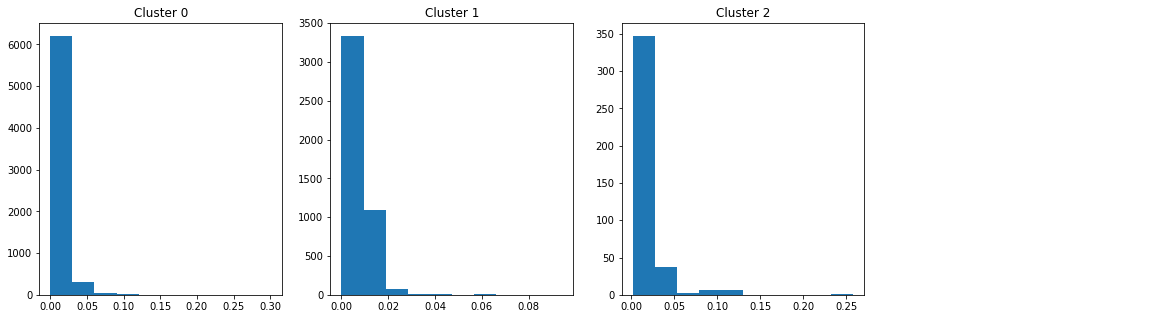

In [ ]:
data_list = []

for i in range(0, n_clusters):
  accounts = users.iloc[labels == i][col]
  data_list.append(accounts)

plot_hist_grid(data_list, n_bins=10, figsize=figsize)

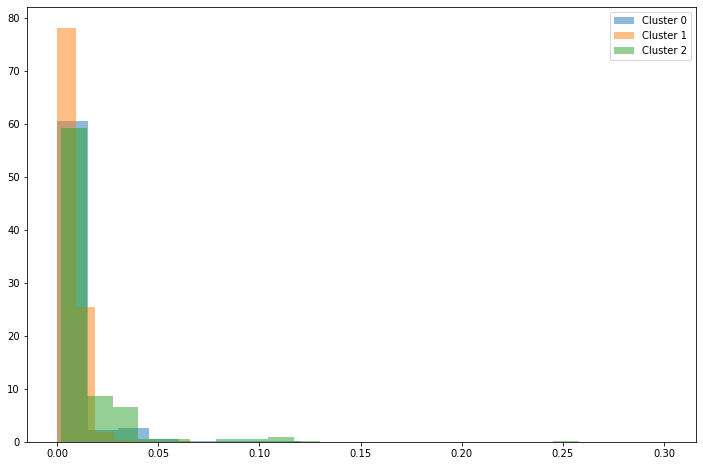

In [ ]:
data_list = []

for i in range(0, n_clusters):
  accounts = users.iloc[labels == i][col]
  data_list.append(accounts)


print_overlapping_histograms(data_list, [20, 10, 20])

# Favorite count entropy distribution per cluster

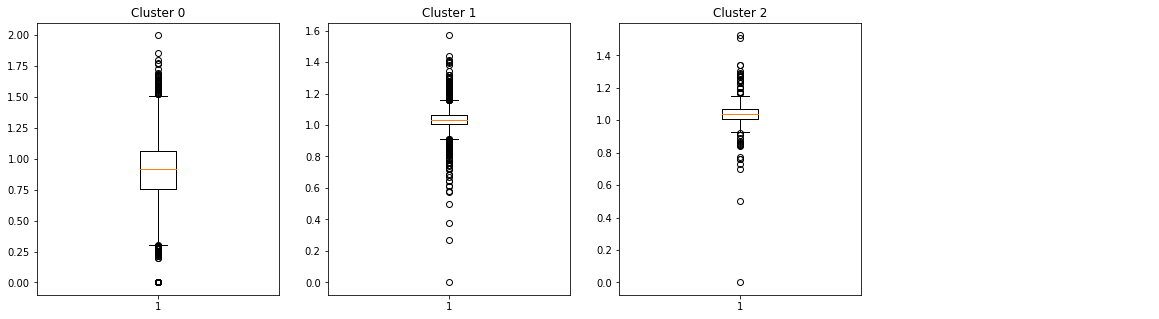

In [ ]:
col = "favorite_count_entropy"
data_list = []

for i in range(0, n_clusters):
  accounts = users.iloc[labels == i][col]
  data_list.append(accounts)

plot_boxplot_grid(data_list, figsize=figsize)

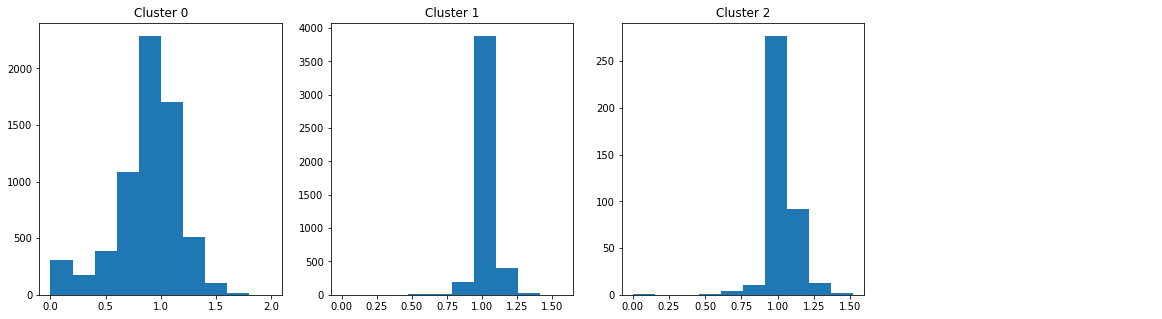

In [ ]:
data_list = []

for i in range(0, n_clusters):
  accounts = users.iloc[labels == i][col]
  data_list.append(accounts)

plot_hist_grid(data_list, n_bins=10, figsize=figsize)

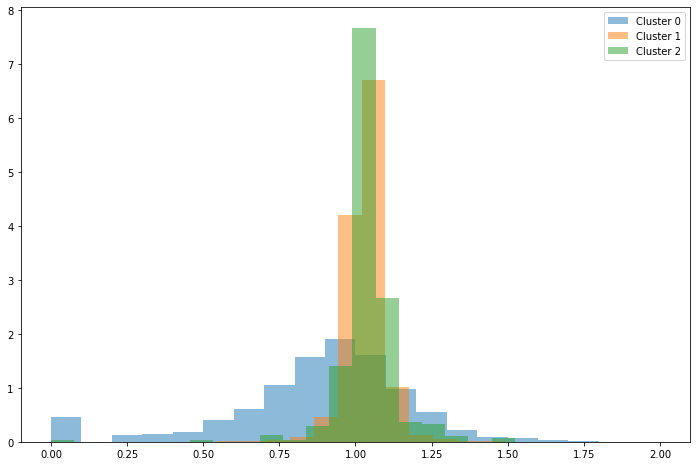

In [ ]:
data_list = []

for i in range(0, n_clusters):
  accounts = users.iloc[labels == i][col]
  data_list.append(accounts)


print_overlapping_histograms(data_list)

# Hashtags number entropy distribution per cluster

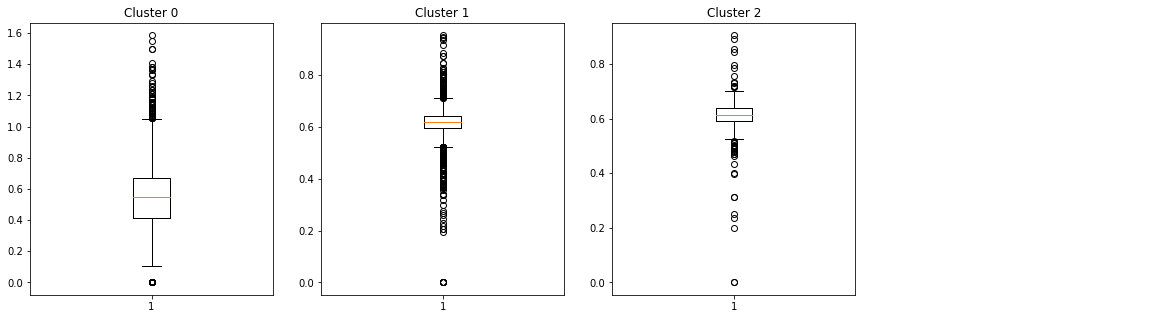

In [ ]:
col = "num_hashtags_entropy"
data_list = []

for i in range(0, n_clusters):
  accounts = users.iloc[labels == i][col]
  data_list.append(accounts)

plot_boxplot_grid(data_list, figsize=figsize)

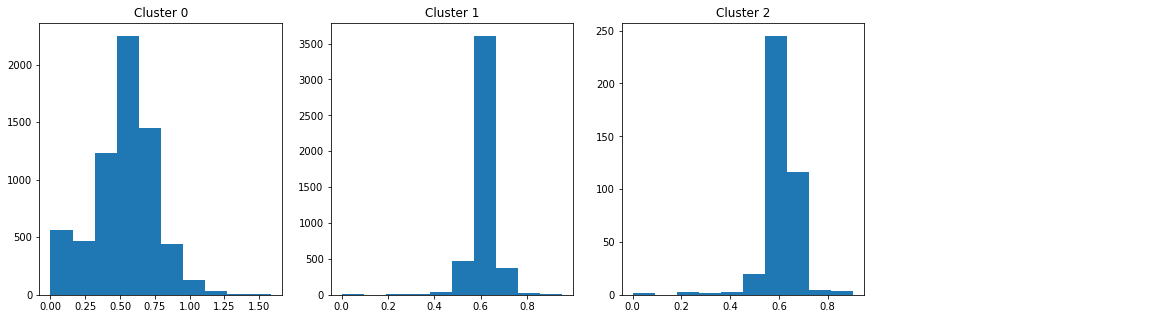

In [ ]:
data_list = []

for i in range(0, n_clusters):
  accounts = users.iloc[labels == i][col]
  data_list.append(accounts)

plot_hist_grid(data_list, n_bins=10, figsize=figsize)

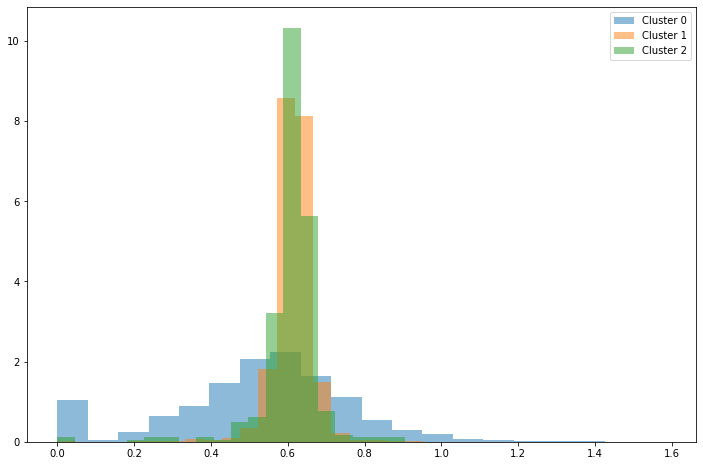

In [ ]:
data_list = []

for i in range(0, n_clusters):
  accounts = users.iloc[labels == i][col]
  data_list.append(accounts)


print_overlapping_histograms(data_list)

# URLS number entropy distribution per cluster

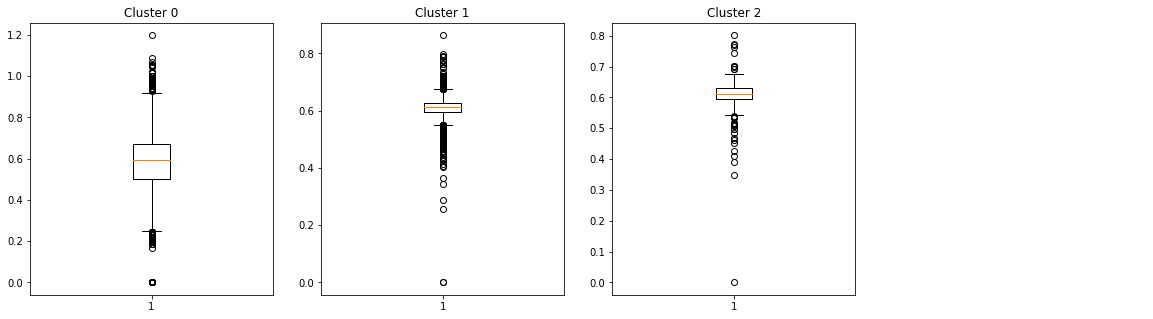

In [ ]:
col = "num_urls_entropy"
data_list = []

for i in range(0, n_clusters):
  accounts = users.iloc[labels == i][col]
  data_list.append(accounts)

plot_boxplot_grid(data_list, figsize=figsize)

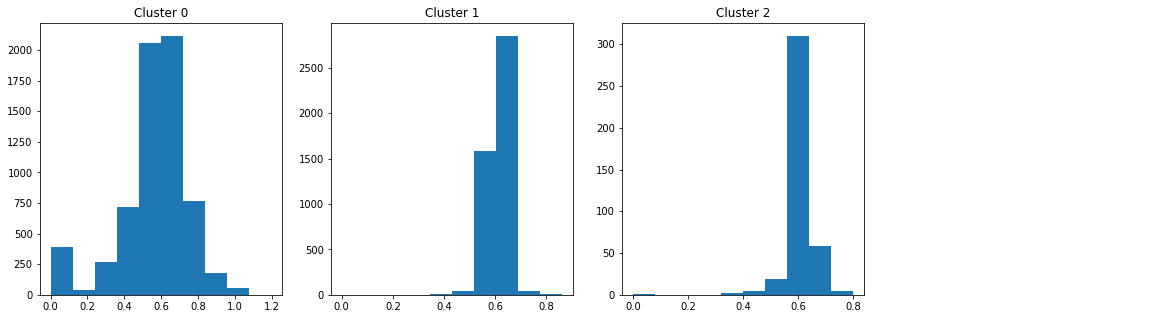

In [ ]:
data_list = []

for i in range(0, n_clusters):
  accounts = users.iloc[labels == i][col]
  data_list.append(accounts)

plot_hist_grid(data_list, n_bins=10, figsize=figsize)

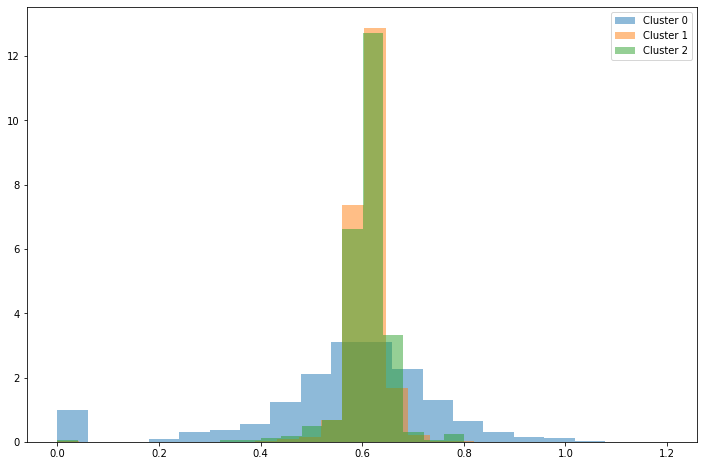

In [ ]:
data_list = []

for i in range(0, n_clusters):
  accounts = users.iloc[labels == i][col]
  data_list.append(accounts)


print_overlapping_histograms(data_list)

# Mentions number entropy distribution per cluster

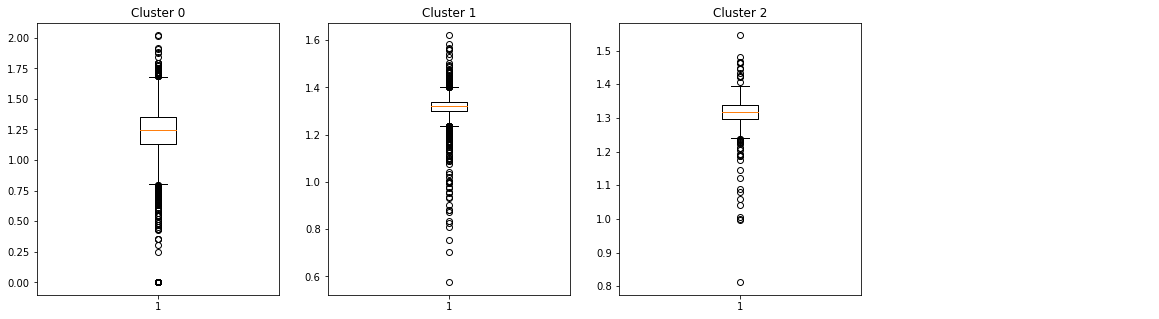

In [ ]:
col = "num_mentions_entropy"
data_list = []

for i in range(0, n_clusters):
  accounts = users.iloc[labels == i][col]
  data_list.append(accounts)

plot_boxplot_grid(data_list, figsize=figsize)

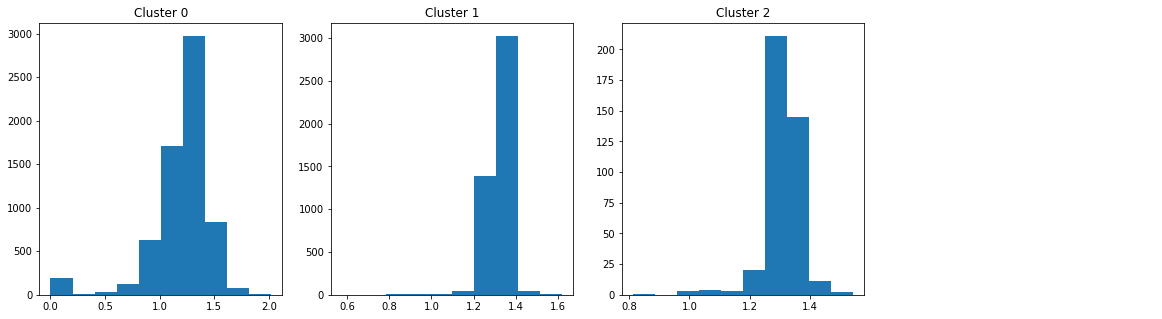

In [ ]:
data_list = []

for i in range(0, n_clusters):
  accounts = users.iloc[labels == i][col]
  data_list.append(accounts)

plot_hist_grid(data_list, n_bins=10, figsize=figsize)

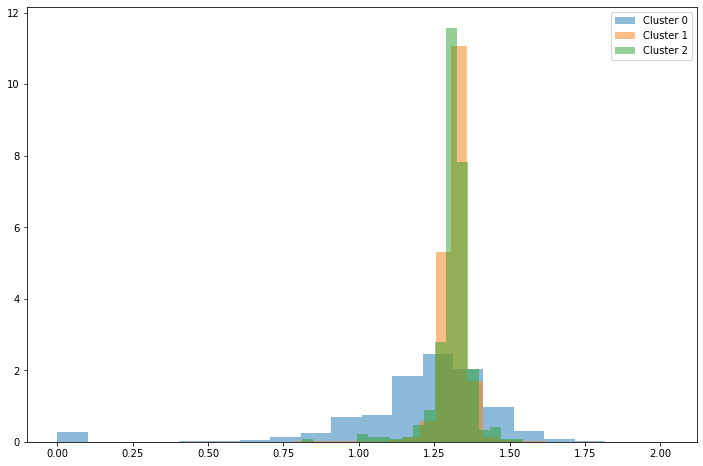

In [ ]:
data_list = []

for i in range(0, n_clusters):
  accounts = users.iloc[labels == i][col]
  data_list.append(accounts)


print_overlapping_histograms(data_list)

# Average text length distribution per cluster

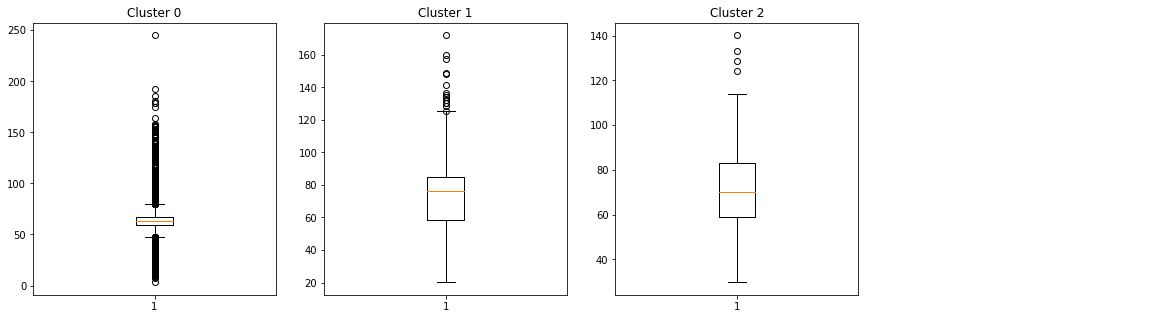

In [ ]:
col = "avg_len"
data_list = []

for i in range(0, n_clusters):
  accounts = users.iloc[labels == i][col]
  data_list.append(accounts)

plot_boxplot_grid(data_list, figsize=figsize)

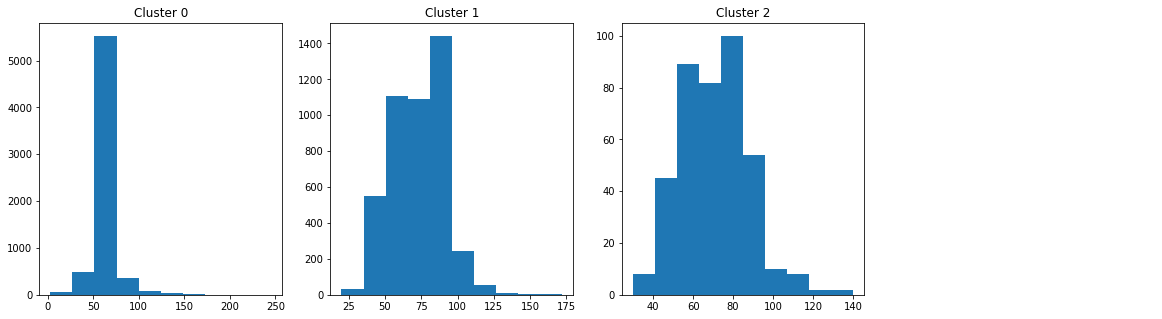

In [ ]:
data_list = []

for i in range(0, n_clusters):
  accounts = users.iloc[labels == i][col]
  data_list.append(accounts)

plot_hist_grid(data_list, n_bins=10, figsize=figsize)

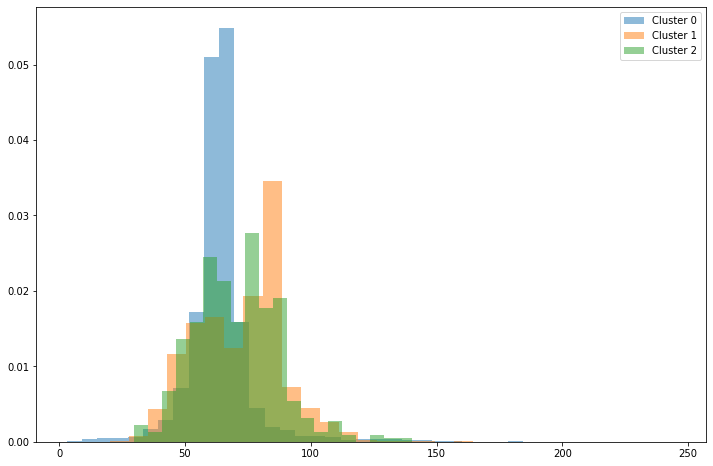

In [ ]:
data_list = []

for i in range(0, n_clusters):
  accounts = users.iloc[labels == i][col]
  data_list.append(accounts)


print_overlapping_histograms(data_list, [40, 20, 20])

# Average special characters distribution per cluster

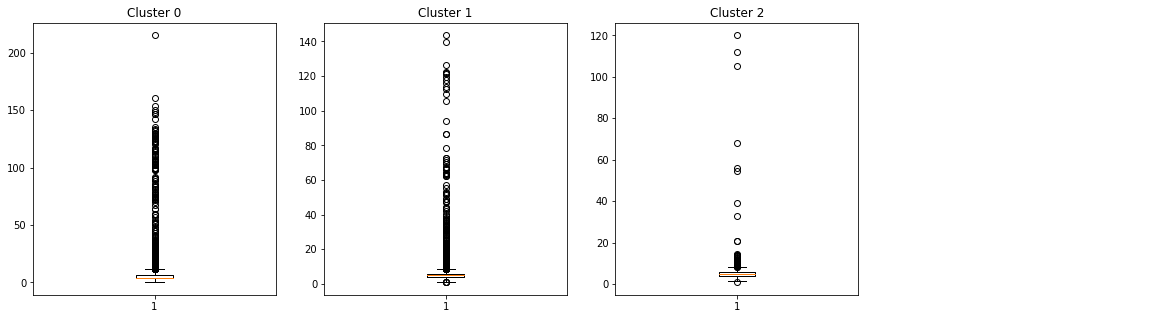

In [ ]:
col = "avg_spc_len"
data_list = []

for i in range(0, n_clusters):
  accounts = users.iloc[labels == i][col]
  data_list.append(accounts)

plot_boxplot_grid(data_list, figsize=figsize)

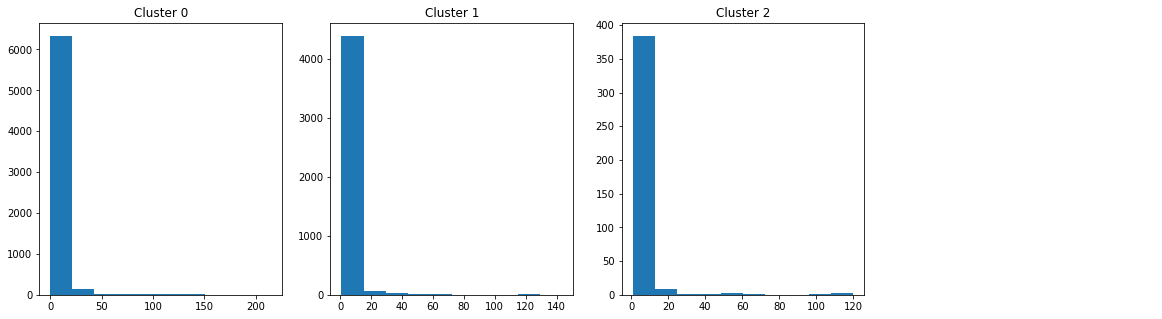

In [ ]:
data_list = []

for i in range(0, n_clusters):
  accounts = users.iloc[labels == i][col]
  data_list.append(accounts)

plot_hist_grid(data_list, n_bins=10, figsize=figsize)

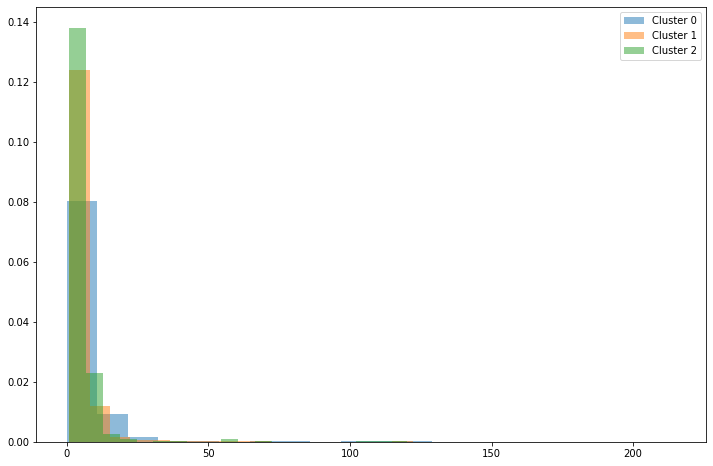

In [ ]:
data_list = []

for i in range(0, n_clusters):
  accounts = users.iloc[labels == i][col]
  data_list.append(accounts)


print_overlapping_histograms(data_list)